# Train Random Forest Classifier on Assembled Dataset

Notes: - Includes data from 1st March 2020 - 31st March 2021

## Importing libraries and dataset

In [1]:

# Import Libraries
import import_ipynb
from importlib import reload

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV, cross_validate
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, make_scorer

from scipy.interpolate import interp1d
from matplotlib.colors import LogNorm

import datetime
from dateutil.relativedelta import relativedelta

from cleanlab.classification import LearningWithNoisyLabels


In [2]:

# Import dataset
ReadCSV = True
if ReadCSV:
    df_ini = pd.read_csv(r'O:\GIRFT DiRAC\FlavienHardy\2_NosocomialInfections\src\0.processing\data\NI_Final_AllIMD.csv')

df_ini['Discharge_date'] = pd.to_datetime(df_ini['Discharge_date'], format='%d/%m/%Y')
df_ini.head(2)


,Unnamed: 0,P_Spell_ID,IMD_score,procedure_group,age_of_patient,SpellCCdays,MORT,Spell_Los,Admission_date,Discharge_date,...,dis_dest_Spell_Non-NHS run,dis_dest_Spell_Non-NHS run .1,dis_dest_Spell_Not known,dis_dest_Spell_Not known: a,dis_dest_Spell_Penal establ,dis_dest_Spell_Repatriation,dis_dest_Spell_Temporary pl,HFRS_Band_Mild,HFRS_Band_Moderate,HFRS_Band_Severe
0,0,1487000,25,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,38,0.0,0,54,2021-02-05,2021-03-31,...,0,0,0,0,0,0,0,0,0,0
1,1,2169012,9,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,75,0.0,0,7,2021-03-24,2021-03-31,...,0,0,0,0,0,0,0,0,0,1


In [3]:

# Set X matrix and y vector | Dropping Methods, Dates, ID features
ColumnList =['Unnamed: 0', 'NC_Method1', 'NC_Method2_15', 'NC_Method2_8','NC_Method4','NI_AllMethods',
             'Diff_EPIstart_Admission',
             'Admission_date', 'Discharge_date',
             'P_Spell_ID']
X_ini = df_ini.drop(columns=ColumnList)
y_ini = df_ini['NI_AllMethods']


if 'UpperLimit' in list(X_ini.columns):
    print('Dropping UpperLimit feature')
    X_ini = X_ini.drop(columns=['UpperLimit'])

# IMD: Keeping IMD score, dropping sub-components
ColumnList = ['IMD_Education, Skills and Training Rank',
            'IMD_Health Deprivation and Disability Rank',
            'IMD_Crime Rank',
            'IMD_Barriers to Housing and Services Rank',
            'IMD_Living Environment Rank',
            'IMD_Rank',
            'IMD_Income Rank',
            'IMD_Employment Rank',
            ]

print('Dropping IMD sub-components')
X_ini = X_ini.drop(columns=ColumnList)

# Dropping last-minute features
X_ini = X_ini.drop(columns=['Diabetes_without', 'procedure_group', 'Total_Hopper_Domains', 'Charlson_Score'])

print('Total number of discharges', X_ini.shape[0])
print('Number of features', X_ini.shape[1])
print('Number of NI', y_ini.sum())
print('Proportion of NI', 100*y_ini.sum()/y_ini.shape[0])

list(X_ini.columns)


Dropping IMD sub-components
Total number of discharges 374244
Number of features 88
Number of NI 29896
Proportion of NI 7.98837122305234


['IMD_score',
 'age_of_patient',
 'SpellCCdays',
 'MORT',
 'Spell_Los',
 'Hopper_Index_1',
 'Hopper_Index_2',
 'Hopper_Index_3',
 'Hopper_Index_4',
 'Hopper_Index_5',
 'Hopper_Index_6',
 'Hopper_Index_7',
 'Periferal_vasc',
 'heart_fail',
 'Acute_MI',
 'cerebral_vasc',
 'dementia',
 'Pulmonary_dis',
 'Connective',
 'Peptic_ulcer',
 'Liver_dis',
 'Diabetes_with',
 'Hemi_para',
 'Renal_dis',
 'cancer',
 'metastatic',
 'Severe_liver',
 'HIV',
 'Obesity',
 'CountSameDay_Covid',
 'CountSameDay_NonCovid',
 'PropMaxPatientsWave_Covid',
 'PropMaxPatientsWave_NonCovid',
 'Severity_Pneumonia',
 'Severity_Kidney',
 'Severity_BloodClotting',
 'Severity_CardiologyCirculation',
 'Severity_Neurology',
 'Severity_DigestiveSystem',
 'Severity_Sepsis',
 'ethnicity_updated_cat_Black or Black British',
 'ethnicity_updated_cat_Mixed',
 'ethnicity_updated_cat_Other Asian',
 'ethnicity_updated_cat_Other ethnic groups',
 'ethnicity_updated_cat_South Asian or South Asian British',
 'ethnicity_updated_cat_White

## Split Dataset and Optimise Model

In [4]:

SplitMethod = 'Conventional'

# Split into training, validation | test sets

def TrainSplitTime(df_ini, val_size, test_size):
    # Sort data according to discharge date
    df = df_ini.sort_values(by=['Discharge_date'], ascending=True)
    
    LenVal = np.floor(val_size*df.shape[0]).astype('int')
    LenTest = np.floor(test_size*df.shape[0]).astype('int')
    LenTrain = df.shape[0] - LenVal - LenTest

    ColumnList =['Unnamed: 0', 'NC_Method1', 'NC_Method2_15', 'NC_Method2_8','NC_Method4','NI_AllMethods',
                 'Diff_EPIstart_Admission',
                 'Admission_date', 'Discharge_date',
                 'P_Spell_ID']
    X_train = df.iloc[0:LenTrain, :].drop(columns=ColumnList)
    X_val = df.iloc[LenTrain:LenTrain+LenVal, :].drop(columns=ColumnList)
    X_test = df.iloc[LenTrain+LenVal:, :].drop(columns=ColumnList)

    y_train = df.iloc[0:LenTrain]['NI_AllMethods']
    y_val = df.iloc[LenTrain:LenTrain+LenVal]['NI_AllMethods']
    y_test = df.iloc[LenTrain+LenVal:]['NI_AllMethods']

    return X_train, X_val, X_test, y_train, y_val, y_test

def Split_TestEndPeriod(df, test_size):
    LenTest = np.floor(test_size*df.shape[0]).astype('int')
    ColumnList =['Unnamed: 0', 'NC_Method1', 'NC_Method2_15', 'NC_Method2_8','NC_Method4','NI_AllMethods',
                 'Diff_EPIstart_Admission',
                 'Admission_date', 'Discharge_date',
                 'P_Spell_ID']

    X_trainval = df.iloc[0:-LenTest:,:].drop(columns=ColumnList)
    y_trainval = df.iloc[0:-LenTest:,:]['NI_AllMethods']
    X_test = df.iloc[-LenTest:,:].drop(columns=ColumnList)
    y_test = df.iloc[-LenTest:,:]['NI_AllMethods']
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.17)
    
    print('The isolated test set covers the end of the March-March period.')
    
    return X_train, X_val, X_test, y_train, y_val, y_test


if SplitMethod == 'Chronological':
    X_train, X_val, X_test, y_train, y_val, y_test = TrainSplitTime(df_ini, val_size=0.15, test_size=0.15)
    print('-----')
    print('Training, validation, test sets follow each other chronologically.')
    
elif SplitMethod == 'Split_TestEndPeriod':
    X_train, X_val, X_test, y_train, y_val, y_test = Split_TestEndPeriod(df_ini, test_size=0.15)

elif SplitMethod == 'Conventional':
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_ini, y_ini, stratify=y_ini, test_size=0.15)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.17)
    
print('Size of TRAINING set:', X_train.shape[0], 'corresponding to', 100*X_train.shape[0]/df_ini.shape[0], '%')
print('Size of VALIDATION set:', X_val.shape[0], 'corresponding to', 100*X_val.shape[0]/df_ini.shape[0], '%')
print('Size of TEST set:', X_test.shape[0], 'corresponding to', 100*X_test.shape[0]/df_ini.shape[0], '%')
print('The discharge_date feature has been removed.')


Size of TRAINING set: 264028 corresponding to 70.54969485148726 %
Size of VALIDATION set: 54079 corresponding to 14.450198266371672 %
Size of TEST set: 56137 corresponding to 15.000106882141063 %
The discharge_date feature has been removed.


In [5]:

# Define classifier to optimise
clf_RF = RandomForestClassifier()

RunOptimisation = False

if RunOptimisation:
    
    # Construct grid of parameters
    n_estimators = [int(x) for x in np.linspace(100, 300, 50)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(60, 100, 20)]
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    class_weight = ['balanced', 'balanced_subsample', None]

    random_grid_long = {'n_estimators':n_estimators,
                   'max_features':max_features,
                   'max_depth':max_depth,
                   'min_samples_split':min_samples_split,
                   'min_samples_leaf':min_samples_leaf,
                   'bootstrap':bootstrap,
                   'class_weight':class_weight}

    random_grid_short = {'n_estimators':n_estimators,
                         'max_features':max_features,
                         'max_depth':max_depth}
    
    # Define CV
    CV = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
    
    # Define metrics of interest: AUROC - AUPR Curve
    metric_ROC_auc = 'roc_auc'

    def metric_PR_auc(y_true, probas_pred):
        p, r, _ = precision_recall_curve(y_true, probas_pred)
        return auc(r, p)
    metric_PR_auc = make_scorer(metric_PR_auc, needs_proba=True)
    
    Scoring = metric_PR_auc

    # Random search training
    clf_RF_random = RandomizedSearchCV(estimator=clf_RF,
                                    param_distributions=random_grid_short,
                                    n_iter=10,
                                    cv=CV,
                                    verbose=2,
                                    random_state=42,
                                    n_jobs=-1,
                                    scoring=metric_PR_auc)
    
    # Run CV and training set and print scores
    clf_RF_random.fit(X_train, y_train)
    print(clf_RF_random.best_params_)


Results for random_grid_short: (metric - PR_auc) \
{'n_estimators': 283, 'max_features': 'sqrt', 'max_depth': 81} \
\
Results for random_grid_long: (metric - PR_auc) \
{'n_estimators': 279, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 62, 'class_weight': None, 'bootstrap': True}



## Train Model

In [6]:

# Define classifier
clf_RF = RandomForestClassifier(n_estimators=279,
                                min_samples_split=10,
                                min_samples_leaf=2,
                                max_depth=62,
                                max_features='auto',
                                bootstrap=True,
                                class_weight=None)

# Train classifier
clf_RF.fit(X_train, y_train)


RandomForestClassifier(max_depth=62, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=279)

## Evaluation: ROC Curve

In [10]:

# Find predicted vectors
y_pred_train = clf_RF.predict(X_train)
y_pred_val_proba = clf_RF.predict_proba(X_val)

# Change Probablity Threshold
Threshold_Val = 0.25
y_pred_val = [1 if y_pred_val_proba[i][1]>Threshold_Val else 0 for i in range(len(y_pred_val_proba))]
y_pred_val_proba =  y_pred_val_proba[:,1]


ROC AUC Value:  0.8902358209160747


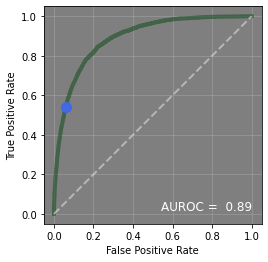

In [12]:

# Find AUROC
fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred_val_proba)
roc_auc = metrics.auc(fpr, tpr)
print('ROC AUC Value: ', roc_auc)

#----------------------------------------
# Plot ROC Curve

# --- Plot ROC Curve
fig, ax = plt.subplots()
CurveOpacity = 0.6
ColorCurve = (26/255, 81/255, 37/255, CurveOpacity)
plt.plot(fpr, tpr, color=ColorCurve, label='AUC = %0.2f' % roc_auc, linewidth=4, zorder=2)

# --- Plot Diagonal Line
ColorDiag = (220/255, 220/255, 220/255, CurveOpacity)
plt.plot([0, 1], [0, 1], color=ColorDiag, linestyle='--', linewidth=2, zorder=2)

# --- Plot current state on ROC curve
FilterThreshold = (threshold==Threshold_Val)
f_FPR = interp1d(threshold, fpr)
f_TPR = interp1d(threshold, tpr)
OpacityPoint = 1
ColorPoint = [65/255, 105/255, 225/255, OpacityPoint]
plt.scatter(x=f_FPR(Threshold_Val), y=f_TPR(Threshold_Val), s=100, color=ColorPoint, zorder=3)

# --- Options
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axis('scaled')
plt.text(0.54, 0.02, 'AUROC =  %0.2f' % roc_auc, color='white', fontsize=12)
ax.set_facecolor([0, 0, 0, 0.5])
ax.grid(b=True, alpha=0.5, zorder=1)

Save = True
if Save:
    fig.savefig('ROC_025.pdf', bbox_inches='tight', format='pdf', dpi=300)



## Plot and Analyse Confusion Matrix

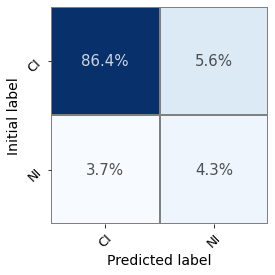

In [422]:

fig2, ax2 = plt.subplots(1, 1, figsize=(12, 4))

# Compute confusion matrix on validation set
CM = confusion_matrix(y_val, y_pred_val, normalize='all')

# Options for annotation and categories
annot_kws={'fontsize':15,
          'alpha':0.8}
Categories = ['CI', 'NI']

# Plot confusion matrix
res = sns.heatmap(CM, annot=True, fmt='0.1%', cmap='Blues', norm=LogNorm(),
           annot_kws=annot_kws,
           linewidth=2,
           xticklabels=Categories,
           yticklabels=Categories,
           square=True,
           cbar=False,
           linecolor='gray')

# Remove ticks on x and y axes
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=13, rotation=45)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=13, rotation=45)

# Add labels
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('Initial label', fontsize=14)

Save = False
if Save:
    fig2.savefig('CM_025.pdf', bbox_inches='tight', format='pdf', dpi=300)


In [11]:

# New predicted NI rate on validation set

def NI_Rate(y_pred_val):
    n_NI_pred = np.sum(y_pred_val)
    n_Infections = len(y_pred_val)
    Prop_pred = 100*n_NI_pred/n_Infections
    return Prop_pred

n_NI_pred = np.sum(y_pred_val)
n_Infections = len(y_pred_val)
Prop_pred = 100*n_NI_pred/n_Infections
print('Number of predicted NI:', n_NI_pred)
print('Out of:', n_Infections, 'infections.')
print('New predicted NI rate:', Prop_pred, '%')


NameError: name 'y_pred_val' is not defined

### Find TPR of each method

In [424]:

Index_pred_positives = list(X_val[ pd.array(y_pred_val)==1 ].index)
Index_pred_negatives = list(X_val[ pd.array(y_pred_val)==0 ].index)

def TPR_Method(Method):
    # Was initially identified as NI by method
    Index_method_positives = list( df_ini[df_ini[Method]==1].index )
    Index_method_negatives = list( df_ini[df_ini[Method]==0].index )

    Index_method_TP = list( set.intersection( set(Index_method_positives), set(Index_pred_positives) ) )
    Index_method_FN = list( set.intersection( set(Index_method_positives), set(Index_pred_negatives) ) )

    TPR_Method = 100 * len(Index_method_TP) / (len(Index_method_TP)+len(Index_method_FN))
    print('TPR of', Method, TPR_Method, '%')

Methods = ['NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NC_Method4']
for method in Methods:
    TPR_Method(method)
    

TPR of NC_Method1 45.839636913767016 %
TPR of NC_Method2_15 87.7079482439926 %
TPR of NC_Method2_8 70.48192771084338 %
TPR of NC_Method4 12.0 %


## Extract Feature Importance

### Using Mean Decrease in Impurity (MDI)

In [425]:

FeatureImportance = pd.DataFrame({'Features':list(X_train.columns), 'Importance':clf_RF.feature_importances_}).sort_values('Importance', ascending=False)
FeatureImportance[0:10]


,Features,Importance
4,Spell_Los,0.256916
31,PropMaxPatientsWave_Covid,0.094806
29,CountSameDay_Covid,0.074229
32,PropMaxPatientsWave_NonCovid,0.069108
30,CountSameDay_NonCovid,0.060907
1,age_of_patient,0.055403
0,IMD_score,0.051502
87,HFRS_Band_Severe,0.022010
2,SpellCCdays,0.017271
3,MORT,0.017110


Notes:
- Biased towards high cardinality features
- Computed on training set, does not reflect ability of feature to contribute to useful predictions when applied to test set


### Using Permutation Importance

In [447]:

from sklearn.inspection import permutation_importance
r = permutation_importance(clf_RF, X_ini, y_ini, n_repeats=1, random_state=0)
sorted_idx = r.importances_mean.argsort()

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2*r.importances_std[i]>0:
#         print(f'{X_trainval.columns[i]:<8}'
#               ': \t'
#               f'{r.importances_mean[i]:.3f}')

sorted_idx = r.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(5,25))
ax.boxplot(r.importances[sorted_idx].T,
          vert=False, labels=X_ini.columns[sorted_idx]);


KeyboardInterrupt: 

### Permutation Importance using rfpimp

In [426]:

import rfpimp

I = rfpimp.permutation_importances(clf_RF, X_ini, y_ini, rfpimp.oob_classifier_accuracy)


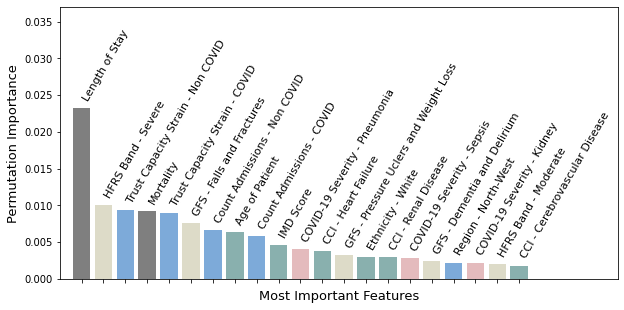

In [446]:

C = 21
ListIndex_Sub = ListIndex[0:C]
ListValues_Sub = ListValues[0:C]

# Renaming values for the plot
DictNames = {'Spell_Los':'Length of Stay',
            'PropMaxPatientsWave_Covid':'Trust Capacity Strain - COVID',
            'Charlson_Score':'Charlson Score',
            'PropMaxPatientsWave_NonCovid':'Trust Capacity Strain - Non COVID',
            'HFRS_Band_Severe':'HFRS Band - Severe',
            'CountSameDay_Covid':'Count Admissions - COVID',
            'age_of_patient':'Age of Patient',
            'MORT':'Mortality',
            'CountSameDay_NonCovid':'Count Admissions - Non COVID',
            'Severity_Pneumonia':'COVID-19 Severity - Pneumonia',
            'IMD_score': 'IMD Score',
            'Hopper_Index_1': 'GFS - Dementia and Delirium',
            'Hopper_Index_3':'GFS - Falls and Fractures',
            'Hopper_Index_4':'GFS - Pressure Uclers and Weight Loss',
            'heart_fail':'CCI - Heart Failure',
            'Severity_Kidney':'COVID-19 Severity - Kidney',
            'HFRS_Band_Moderate':'HFRS Band - Moderate',
            'cerebral_vasc':'CCI - Cerebrovascular Disease',
            'sex_Male':'Sex - Male',
            'region_North West':'Region - North-West',
            'Severity_Neurology':'Severity - Neurology',
            'cancer':'CCI - Cancer',
            'Severity_Sepsis':'COVID-19 Severity - Sepsis',
            'Renal_dis':'CCI - Renal Disease',
            'ethnicity_updated_cat_White':'Ethnicity - White'}
ListIndex_Sub = [ DictNames.get(n, n)  for n in ListIndex_Sub]

fig, ax = plt.subplots(figsize=(10,5))
ListIndex = list(I.index)
ListValues = [I.values[element,0] for element in range(len(I))]
df_FeatureImportance = pd.DataFrame(data={'Feature':ListIndex_Sub, 'Importance':ListValues_Sub})
df_FeatureImportance

Colorbar = [137/255, 176/255, 174/255, 1]
Colorbar2 = np.array([233/255, 230/255, 211/255])*0.95
Colorbar3 = [125/255, 170/255, 217/255, 1]
Colorbar4 = np.array([251/255, 200/255, 202/255, 1])*0.9
Colorbar5 = [0/255, 0/255, 0/255, 0.5]

Features_NI = ['Trust Capacity Strain - COVID', 'Trust Capacity Strain - Non COVID',
              'Count Admissions - COVID', 'Count Admissions - Non COVID',
              'Region - North-West']
Features_Frailty = ['Charlson Score', 'HFRS Band - Severe', 'HFRS Band - Moderate',
                   'GFS - Dementia and Delirium', 'GFS - Falls and Fractures', 'GFS - Pressure Uclers and Weight Loss',
                   'Heart Failure', 'cerebral_vasc',
                   'Cerebral Vascular Disease', 'Cancer']
Features_Severity = ['COVID-19 Severity - Pneumonia', 'COVID-19 Severity - Kidney', 'COVID-19 Severity - Neurology',
                    'COVID-19 Severity - Sepsis']
Features_Outcomes = ['Mortality', 'Length of Stay']
ColorList = [Colorbar3 if (x in Features_NI) else ( Colorbar2 if (x in Features_Frailty) else ( Colorbar4 if (x in Features_Severity) else (Colorbar5 if (x in Features_Outcomes) else Colorbar)) )  for x in ListIndex_Sub ]

ColorText = [250/255, 249/255, 249/255]

plt.bar(df_FeatureImportance['Feature'], df_FeatureImportance['Importance'],
                    color=ColorList, zorder=2)

for index, value in enumerate(df_FeatureImportance['Feature'][0:C]):
    plt.text(index, 0.001+df_FeatureImportance.loc[index, 'Importance'], str(value),
             rotation='60', weight='normal', size=11,
             zorder=2) #, color=ColorText
    
plt.ylim(0,0.037)
plt.xlim(-1,24.5)
ax.set_xticklabels([]);
plt.xlabel('Most Important Features', size=13)
plt.ylabel('Permutation Importance', size=13)

plt.grid(alpha=0, zorder=1)
ax.set_facecolor((0, 0, 0, 0))

SaveFigure = True
if SaveFigure:
    plt.savefig(r'O:\GIRFT DiRAC\FlavienHardy\2_NosocomialInfections\src\1.models\FeatureImportance.pdf',
               dpi=300, format='pdf')



## Find upper limit

In [7]:

# Find upper limit
def UpperLimit(df):
    
    Filter1 = (df['NC_Method1']+df['NC_Method4']>=1)
    Filter2 = (df['POD_EL']+df['POD_DC']>=1) & (df['Spell_Los']>2)
    Filter3 = (df['POD_EM']==1) & (df['Spell_Los']>2) & (df['Diff_EPIstart_Admission']>0)
    
    df['UpperLimit'] = np.where(Filter1|Filter2|Filter3, 1, 0)

    return df

# df_ini = UpperLimit(df_ini)
df_ini.head(2)

df_ini[['Admission_date','Discharge_date']]

,Admission_date,Discharge_date
0,2021-02-05,2021-03-31
1,2021-03-24,2021-03-31
2,2020-12-31,2021-03-31
3,2021-03-22,2021-03-31
4,2021-02-04,2021-03-31
...,...,...
374239,2020-02-24,2020-03-02
374240,2020-02-20,2020-03-02
374241,2019-12-04,2020-03-02
374242,2020-03-01,2020-03-01


## Visualise Time Evolution

### Apply model to test set

In [770]:

# Filter_Wave1 = (df_ini.loc[X_trainval.index, 'Admission_date'] <= pd.to_datetime('2020-08-01', format='%Y-%m-%d') )


In [8]:

# Retrain classifier on training+validation dataset
# clf_RF.fit(X_ini, y_ini)
clf_RF.fit(X_trainval, y_trainval)


RandomForestClassifier(max_depth=62, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=279)

In [12]:

Origin_DischargeDate = pd.to_datetime('01/03/2020', format='%d/%m/%Y')
Origin_AdmissionDate = pd.to_datetime('07/12/2012', format='%d/%m/%Y')

# Apply model to held-out test set
X_application = X_ini
y_application = y_ini

# Create dataframe from model predictions

# Applying model to test set
y_pred_proba_application_ini = clf_RF.predict_proba(X_application)

# Changing Probablity Threshold
Threshold_Val2 = 0.18
y_pred_application = [1 if y_pred_proba_application_ini[i][1]>Threshold_Val2 else 0 for i in range(len(y_pred_proba_application_ini))]
y_pred_proba_application =  y_pred_proba_application_ini[:,1]
print('NI rate on test set:', NI_Rate(y_pred_application), '%')

Threshold_Val_Wave2 = 0.27
y_pred_application_2 = [1 if y_pred_proba_application_ini[i][1]>Threshold_Val_Wave2 else 0 for i in range(len(y_pred_proba_application_ini))]
y_pred_proba_application_2 =  y_pred_proba_application_ini[:,1]

Threshold_Val_InBetween = 0.39
y_pred_application_3 = [1 if y_pred_proba_application_ini[i][1]>Threshold_Val_InBetween else 0 for i in range(len(y_pred_proba_application_ini))]
y_pred_proba_application_3 =  y_pred_proba_application_ini[:,1]


# Calculating AUROC on test set
fpr, tpr, threshold = metrics.roc_curve(y_application, y_pred_proba_application)
roc_auc = metrics.auc(fpr, tpr)
print('ROC AUC Value on current set: ', roc_auc)


NI rate on test set: 14.013317514776457 %
ROC AUC Value on current set:  0.9798264440567137


In [36]:

df_ini_UL = UpperLimit(df_ini)
df_ini_UL['Admission_date'] = pd.to_datetime(df_ini_UL['Admission_date'], format='%Y-%m-%d')
df_ini_UL['Discharge_date'] = pd.to_datetime(df_ini_UL['Discharge_date'], format='%Y-%m-%d')
# list(df_ini_UL.columns)
df_ini_UL.head()


,Unnamed: 0,P_Spell_ID,IMD_score,procedure_group,age_of_patient,SpellCCdays,MORT,Spell_Los,Admission_date,Discharge_date,...,dis_dest_Spell_Non-NHS run .1,dis_dest_Spell_Not known,dis_dest_Spell_Not known: a,dis_dest_Spell_Penal establ,dis_dest_Spell_Repatriation,dis_dest_Spell_Temporary pl,HFRS_Band_Mild,HFRS_Band_Moderate,HFRS_Band_Severe,UpperLimit
0,0,1487000,25,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,38,0.0,0,54,2021-02-05,2021-03-31,...,0,0,0,0,0,0,0,0,0,1
1,1,2169012,9,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,75,0.0,0,7,2021-03-24,2021-03-31,...,0,0,0,0,0,0,0,0,1,0
2,2,2201273,2,W461~Z943~U212~Y982~Z924~Z401~U051~Y981~-1~-1~...,90,0.0,0,90,2020-12-31,2021-03-31,...,0,0,0,0,0,0,0,0,1,0
3,3,2947750,11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,39,0.0,0,9,2021-03-22,2021-03-31,...,0,0,0,0,0,0,0,0,0,0
4,4,3445944,30,U212~Y981~Z411~Z941~Z413~Z941~Z421~X403~X404~X...,52,0.0,0,55,2021-02-04,2021-03-31,...,0,0,0,0,0,0,0,0,0,1


In [37]:
Filter = df_ini_UL.loc[:,'NC_Method2_15'] + df_ini_UL.loc[:,'NC_Method2_8']>=1
df_ini_UL.loc[Filter,'Diff_EPIstart_Admission'].describe()

count    15235.000000
mean        20.712110
std         18.938822
min          8.000000
25%         10.000000
50%         14.000000
75%         23.000000
max        281.000000
Name: Diff_EPIstart_Admission, dtype: float64

### Create visualisation dataframe

In [38]:

# in df_date: df_Assembled instead of df_ini??
# The peaks seem to be more coherent, as shown in 4-fh-assembly

def DataFrameVisualisation(df):
    # Add Initial labels
    Methods = ['P_Spell_ID', 'NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NC_Method4', 'NI_AllMethods', 'UpperLimit', 'age_of_patient']
    df_Visualisation = df.loc[X_application.index][Methods]
    Dates = ['Admission_date', 'Discharge_date', 'Diff_EPIstart_Admission']
    df_Dates = df.loc[X_application.index, Dates]

    # Add model predictions and admission/discharge dates
    df_Visualisation['Predictions_Proba'] = y_pred_proba_application_ini[:,1]
    df_Visualisation['Predictions'] = y_pred_application
    df_Visualisation['Predictions_2'] = y_pred_application_2 # With second threshold for wave 2
    df_Visualisation['Predictions_3'] = y_pred_application_3 # With third threshold for period between waves
    df_Visualisation['Discharge Date'] = pd.to_datetime(df_Dates['Discharge_date'], format='%Y-%m-%d')
    df_Visualisation['Admission Date'] = pd.to_datetime(df_Dates['Admission_date'], format='%Y-%m-%d')
    
    # Add infection date for NIs
    df_Visualisation['Diff_EPIstart_Admission'] = df_Dates['Diff_EPIstart_Admission']
    Offset = (df_Visualisation['Diff_EPIstart_Admission']).apply(lambda x: pd.Timedelta(x, unit='D'))
    Offset_Pred = (df_Visualisation['Diff_EPIstart_Admission']).apply(lambda x: pd.Timedelta(x, unit='D'))
    
    Filter_Age20 = (df_Visualisation['age_of_patient']<=20)
    Filter_Age2060 = (df_Visualisation['age_of_patient']>20) & (df_Visualisation['age_of_patient']<=60)
    Filter_Age6080 = (df_Visualisation['age_of_patient']>60) & (df_Visualisation['age_of_patient']<=80)
    Filter_Age80 = (df_Visualisation['age_of_patient']>80)

    # Add Date of Symptom Onset for NIs
#     Offset[Filter_Age20] += pd.Timedelta(-2, unit='D')
#     Offset[Filter_Age2060] += pd.Timedelta(-7, unit='D')
#     Offset[Filter_Age6080] += pd.Timedelta(-5, unit='D')
#     Offset[Filter_Age80] += pd.Timedelta(-3, unit='D')
    
#     Offset_Pred[Filter_Age20] += pd.Timedelta(-2, unit='D')
#     Offset_Pred[Filter_Age2060] += pd.Timedelta(-7, unit='D')
#     Offset_Pred[Filter_Age6080] += pd.Timedelta(-5, unit='D')
#     Offset_Pred[Filter_Age80] += pd.Timedelta(-3, unit='D')
    
    # Add infection date for CIs
    Filter_CI = (df_Visualisation['NI_AllMethods']==0)
#     Filter_CI = (df_Visualisation['Diff_EPIstart_Admission']==0)
    Offset[Filter_CI & Filter_Age20] = pd.Timedelta(-2, unit='D')
    Offset[Filter_CI & Filter_Age2060] = pd.Timedelta(-7, unit='D')
    Offset[Filter_CI & Filter_Age6080] = pd.Timedelta(-5, unit='D')
    Offset[Filter_CI & Filter_Age80] = pd.Timedelta(-3, unit='D')
    
    # Add infection date for PREDICTED CIs
#     Filter_Pred_CI = (df_Visualisation['Diff_EPIstart_Admission']==0)
    Filter_Pred_CI = (df_Visualisation['Predictions']==0)
    Offset_Pred[Filter_Pred_CI & Filter_Age20] = pd.Timedelta(-7, unit='D')
    Offset_Pred[Filter_Pred_CI & Filter_Age2060] = pd.Timedelta(-7, unit='D')
    Offset_Pred[Filter_Pred_CI & Filter_Age6080] = pd.Timedelta(-5, unit='D')
    Offset_Pred[Filter_Pred_CI & Filter_Age80] = pd.Timedelta(-3, unit='D')
    
    df_Visualisation['Infection Date'] = df_Visualisation['Admission Date']+Offset
    df_Visualisation['Infection Date, Predictions'] = df_Visualisation['Admission Date']+Offset_Pred
    
    # Reorder Columns
    ColumnList = ['P_Spell_ID', 'Admission Date', 'Discharge Date', 'Diff_EPIstart_Admission', 'Infection Date',
                  'NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NC_Method4', 'NI_AllMethods',
                  'Predictions', 'UpperLimit', 'age_of_patient', 'Infection Date, Predictions', 'Predictions_Proba',
                  'Predictions_2', 'Predictions_3']
    df_Visualisation = df_Visualisation[ColumnList]
    
    return df_Visualisation

df_Visualisation = DataFrameVisualisation(df_ini_UL)
df_Visualisation.head(2)


,P_Spell_ID,Admission Date,Discharge Date,Diff_EPIstart_Admission,Infection Date,NC_Method1,NC_Method2_15,NC_Method2_8,NC_Method4,NI_AllMethods,Predictions,UpperLimit,age_of_patient,"Infection Date, Predictions",Predictions_Proba,Predictions_2,Predictions_3
0,1487000,2021-02-05,2021-03-31,45,2021-03-22,0,1,1,0,1,1,1,38,2021-03-22,0.478161,1,1
1,2169012,2021-03-24,2021-03-31,0,2021-03-19,0,0,0,0,0,0,0,75,2021-03-19,0.126574,0,0


In [39]:
 
# Creating columnm with wave-specific predictions

# Initialise new column
df_Visualisation.loc[:, 'Predictions Waves'] = -1

# First Wave
Filter_Date1 = df_Visualisation.loc[:,'Infection Date']<pd.to_datetime('2020-06-25', format='%Y-%m-%d')
Filter_Wave1 = df_Visualisation.loc[:, 'Predictions_Proba'] >= 0.18
df_Visualisation.loc[ Filter_Date1, 'Predictions Waves' ] = 0
df_Visualisation.loc[ Filter_Date1 & Filter_Wave1, 'Predictions Waves' ] = 1

# In-Between Period
Filter_Date2 =  (df_Visualisation.loc[:,'Infection Date']>=pd.to_datetime('2020-06-25', format='%Y-%m-%d')) & (df_Visualisation.loc[:,'Infection Date']<pd.to_datetime('2020-10-15', format='%Y-%m-%d'))
Filter_Wave2 = df_Visualisation.loc[:, 'Predictions_Proba'] >= 0.39
df_Visualisation.loc[ Filter_Date2, 'Predictions Waves' ] = 0
df_Visualisation.loc[ Filter_Date2 & Filter_Wave2, 'Predictions Waves' ] = 1

# Second Wave
Filter_Date3 =  df_Visualisation.loc[:,'Infection Date']>=pd.to_datetime('2020-10-15', format='%Y-%m-%d')
Filter_Wave3 = df_Visualisation.loc[:, 'Predictions_Proba'] >= 0.27
df_Visualisation.loc[ Filter_Date3, 'Predictions Waves' ] = 0
df_Visualisation.loc[ Filter_Date3 & Filter_Wave3, 'Predictions Waves' ] = 1


df_Visualisation.loc[ Filter_Date3 , 'Predictions Waves' ]

Save = False
if Save:
    df_Visualisation.to_csv(r'O:\GIRFT DiRAC\FlavienHardy\2_NosocomialInfections\src\0.processing\data\Predictions_21.08.25_SeparateWaves.csv')
    

In [133]:

SaveCSV = False
if SaveCSV:
     df_Visualisation.to_csv(r'O:\GIRFT DiRAC\FlavienHardy\2_NosocomialInfections\src\0.processing\data\Predictions_21.07.22.csv')


### Calculate NI rate within time segments

In [16]:

# Choice of Date feature
DateFeature = 'Infection Date'
StartDate_ini = Origin_DischargeDate

# Initialising lists
CountList = []
CountList_Prep = []
PropList = []
PropList_1 = []
PropList_2_15 = []
PropList_2_8 = []
PropList_4 = []
PropList_Predictions = []
PropList_UpperLimit = []

ConfBands_Lower = []
ConfBands_Upper = []

StartDate_List = []
EndDate_List = []

for k in range(0, 56):

    # Limits of time period
    Delta = relativedelta(days=7)
    StartDate = StartDate_ini + k*Delta
    EndDate = StartDate + Delta
    StartDate_List.append(StartDate)
    EndDate_List.append(EndDate)

    # Segment of df within time period
    df_Visualisation.loc[:, 'DatePeriod'] = np.where( (StartDate<=df_Visualisation.loc[:,DateFeature]) & (df_Visualisation.loc[:,DateFeature]<EndDate), 1, 0 )
    FilterDate = df_Visualisation.loc[:, 'DatePeriod'] == 1 
    IndexList_Period = df_Visualisation[FilterDate].index
    
    if DateFeature=='Infection Date':
        df_Visualisation['DatePeriod_Pred'] = np.where( (StartDate<=df_Visualisation[DateFeature+', Predictions']) & (df_Visualisation[DateFeature+', Predictions']<EndDate), 1, 0 )
    else:
        df_Visualisation['DatePeriod_Pred'] = np.where( (StartDate<=df_Visualisation[DateFeature]) & (df_Visualisation[DateFeature]<EndDate), 1, 0 )
    FilterDate_Pred = df_Visualisation['DatePeriod_Pred'] == 1 
    IndexList_Period_Pred = df_Visualisation[FilterDate_Pred].index
    
    # Calculate NI rate using all methods and predictions    
    Columns = ['NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NC_Method4','NI_AllMethods']
    dict = {}
    for column in Columns:
        Sum = df_ini.loc[IndexList_Period, column].sum()
        Count = df_ini.loc[IndexList_Period, column].shape[0]
        Prop = 100 * Sum / Count
        dict[column]=Prop
            
    PropList_1.append(dict['NC_Method1'])
    PropList_2_15.append(dict['NC_Method2_15'])
    PropList_2_8.append(dict['NC_Method2_8'])
    PropList_4.append(dict['NC_Method4'])
    PropList.append(dict['NI_AllMethods'])
    
    # Add count of infections
#     Filter = (StartDate<=pd.to_datetime(df_ini['Discharge_date'], format='%d/%m/%Y')) & (pd.to_datetime(df_ini['Discharge_date'], format='%d/%m/%Y')<EndDate)
#     CountList.append(df_ini[Filter].shape[0])
    CountList.append(df_ini.loc[IndexList_Period].shape[0])
    CountList_Prep.append(df_Visualisation[FilterDate_Pred]['Predictions'].sum())
    
    # Add model predictions
    if DateFeature=='Infection Date':
        if EndDate<pd.to_datetime('2020-06-25', format='%Y-%m-%d'):
            Sum = df_Visualisation[FilterDate_Pred]['Predictions'].sum()
            Count = df_Visualisation[FilterDate_Pred]['Predictions'].shape[0]
            Prop = 100 * Sum / Count
            PropList_Predictions.append(Prop)
            
            # Confidance Bands - Lower
            Filter_1 = FilterDate_Pred & (df_Visualisation['Predictions_Proba'] >= 0.18-0.025)
            Filter_2 = FilterDate_Pred & (df_Visualisation['Predictions_Proba'] >= 0.18+0.025)
            Bound_1 = np.where(Filter_1, 1, 0)
            Bound_2 = np.where(Filter_2, 1, 0)
            Sum_1 = Bound_1.sum()
            Count_1 = df_Visualisation[FilterDate_Pred]['Predictions'].shape[0]
            Prop_1 = 100 * Sum_1 / Count_1
            ConfBands_Upper.append(Prop_1)
            # Confidance Bands - Upper
            Sum_2 = Bound_2.sum()
            Count_2 = df_Visualisation[FilterDate_Pred]['Predictions'].shape[0]
            Prop_2 = 100 * Sum_2 / Count_2
            ConfBands_Lower.append(Prop_2)
            
            
        elif EndDate>=pd.to_datetime('2020-06-25', format='%Y-%m-%d') and EndDate<pd.to_datetime('2020-10-15', format='%Y-%m-%d'):
            Sum = df_Visualisation[FilterDate_Pred]['Predictions_3'].sum()
            Count = df_Visualisation[FilterDate_Pred]['Predictions_3'].shape[0]
            Prop = 100 * Sum / Count
            PropList_Predictions.append(Prop)
            
            # Confidance Bands - Lower
            Filter_1 = FilterDate_Pred & (df_Visualisation['Predictions_Proba'] >= 0.39-0.025)
            Filter_2 = FilterDate_Pred & (df_Visualisation['Predictions_Proba'] >= 0.39+0.025)
            Bound_1 = np.where(Filter_1, 1, 0)
            Bound_2 = np.where(Filter_2, 1, 0)
            Sum_1 = Bound_1.sum()
            Count_1 = df_Visualisation[FilterDate_Pred]['Predictions'].shape[0]
            Prop_1 = 100 * Sum_1 / Count_1
            ConfBands_Upper.append(Prop_1)
            # Confidance Bands - Upper
            Sum_2 = Bound_2.sum()
            Count_2 = df_Visualisation[FilterDate_Pred]['Predictions'].shape[0]
            Prop_2 = 100 * Sum_2 / Count_2
            ConfBands_Lower.append(Prop_2)
            
        else:
            Sum = df_Visualisation[FilterDate_Pred]['Predictions_2'].sum()
            Count = df_Visualisation[FilterDate_Pred]['Predictions_2'].shape[0]
            Prop = 100 * Sum / Count
            PropList_Predictions.append(Prop)
            
            # Confidance Bands - Lower
            Filter_1 = FilterDate_Pred & (df_Visualisation['Predictions_Proba'] >= 0.27-0.025)
            Filter_2 = FilterDate_Pred & (df_Visualisation['Predictions_Proba'] >= 0.27+0.025)
            Bound_1 = np.where(Filter_1, 1, 0)
            Bound_2 = np.where(Filter_2, 1, 0)
            Sum_1 = Bound_1.sum()
            Count_1 = df_Visualisation[FilterDate_Pred]['Predictions'].shape[0]
            Prop_1 = 100 * Sum_1 / Count_1
            ConfBands_Upper.append(Prop_1)
            # Confidance Bands - Upper
            Sum_2 = Bound_2.sum()
            Count_2 = df_Visualisation[FilterDate_Pred]['Predictions'].shape[0]
            Prop_2 = 100 * Sum_2 / Count_2
            ConfBands_Lower.append(Prop_2)
            
    else:
            Sum = df_Visualisation[FilterDate_Pred]['Predictions'].sum()
            Count = df_Visualisation[FilterDate_Pred]['Predictions'].shape[0]
            Prop = 100 * Sum / Count
            PropList_Predictions.append(Prop)
        
#     print('------')
#     print('Date:', StartDate)
#     print('Sum:', Sum)
#     print('Count:', Count)
#     print('Prop:', Prop)
    
    # UpperLimit
    Sum = df_Visualisation[FilterDate]['UpperLimit'].sum()
    Count = df_Visualisation[FilterDate]['UpperLimit'].shape[0]
    Prop = 100 * Sum / Count
    PropList_UpperLimit.append(Prop)

# Adding proportions into a dataframe
d = {DateFeature:StartDate_List, 'NC_Method1':PropList_1,'NC_Method2_15':PropList_2_15,
     'NC_Method2_8':PropList_2_8, 'NC_Method4':PropList_4, 'NI_AllMethods':PropList,
     'Predictions':PropList_Predictions, 'Upper Limit':PropList_UpperLimit,
     'Number Infections':CountList, 'Number NI':CountList_Prep,
     'ConfidenceBand_Lower':ConfBands_Lower, 'ConfidenceBand_Upper':ConfBands_Upper}
df = pd.DataFrame(data=d)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

Window = 5
# Add rolling average
ColumnList = ['NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NC_Method4','NI_AllMethods',
              'Predictions', 'Upper Limit', 'Number Infections', 'Number NI',
              'ConfidenceBand_Lower', 'ConfidenceBand_Upper']
for column in ColumnList:
    df['RollingAverage_'+column] = df[column].rolling(window = Window, min_periods=Window).mean()
#     df['RollingAverage_'+column] = df[column].ewm(com=1, adjust=True).mean()
#     df['RollingAverage_'+column] = moving_average(df[column], Window)

df.head(5)



,Infection Date,NC_Method1,NC_Method2_15,NC_Method2_8,NC_Method4,NI_AllMethods,Predictions,Upper Limit,Number Infections,Number NI,...,RollingAverage_NC_Method2_15,RollingAverage_NC_Method2_8,RollingAverage_NC_Method4,RollingAverage_NI_AllMethods,RollingAverage_Predictions,RollingAverage_Upper Limit,RollingAverage_Number Infections,RollingAverage_Number NI,RollingAverage_ConfidenceBand_Lower,RollingAverage_ConfidenceBand_Upper
0,2020-03-01,10.491563,5.575935,9.170946,0.0,17.314747,43.267652,44.093910,1363,527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-08,5.390513,3.210350,5.294681,0.0,9.439387,21.248213,25.658840,4174,892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-15,3.555556,2.170543,3.576227,0.0,6.232558,10.970248,16.713178,9675,1073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-22,3.086969,2.564559,3.983378,0.0,6.096765,8.379292,12.971208,16845,1413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-29,3.425937,2.492121,3.986226,0.0,6.641765,9.103071,11.024863,17134,1565,...,3.202702,5.202292,0.0,9.145044,18.593695,22.0924,9838.2,1094.0,17.343596,21.040078


In [22]:

print(df['RollingAverage_ConfidenceBand_Lower'].mean(),
      df['RollingAverage_Predictions'].mean(),
      df['RollingAverage_ConfidenceBand_Upper'].mean()
     )

9.276560622987759 10.440732929301069 11.819794048259258


<ipython-input-23-a2b98f943cec>:154: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax_Nb.pcolor(x, y, Z, zorder=1, alpha=0.9, cmap='BuPu')


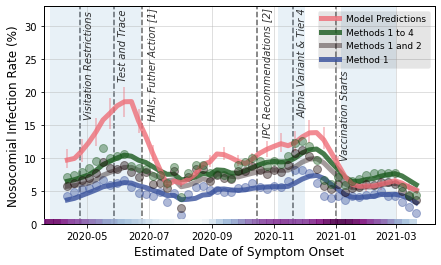

In [23]:

fig, ax = plt.subplots(figsize=(7,4))

yMax = 33
AlphaLines = 0.6
LineStyles = 'dashed'
AlphaZones = 0.1
zorderBack = 0
# First lockdown
# plt.vlines(x=pd.to_datetime('2020-03-26'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
# plt.vlines(x=pd.to_datetime('2020-06-23'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
ax.axvspan(xmin=pd.to_datetime('2020-03-26'), xmax=pd.to_datetime('2020-06-23'), alpha = AlphaZones, zorder=zorderBack)

# Second lockdown
# plt.vlines(x=pd.to_datetime('2020-11-05'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
# plt.vlines(x=pd.to_datetime('2020-12-02'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
ax.axvspan(xmin=pd.to_datetime('2020-11-05'), xmax=pd.to_datetime('2020-12-02'), alpha = AlphaZones, zorder=zorderBack)

# Third lockdown
# plt.vlines(x=pd.to_datetime('2021-01-06'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
ax.axvspan(xmin=pd.to_datetime('2021-01-06'), xmax=pd.to_datetime('2021-03-01'), alpha = AlphaZones, zorder=zorderBack)


# Key Dates
plt.vlines(x=pd.to_datetime('2020-11-20'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
plt.text(x=pd.to_datetime('2020-11-24'), y=16.5, s='Alpha Variant & Tier 4', style='italic',
         rotation='90', size=10,
         color='black', alpha=0.8, zorder=zorderBack)

plt.vlines(x=pd.to_datetime('2020-04-24'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
plt.text(x=pd.to_datetime('2020-04-28'), y=16.2, s='Visitation Restrictions', style='italic',
         rotation='90', size=10,
         color='black', alpha=0.8)

plt.vlines(x=pd.to_datetime('2020-05-28'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
plt.text(x=pd.to_datetime('2020-06-01'), y=22, s='Test and Trace', style='italic',
         rotation='90', size=10,
         color='black', alpha=0.8)

plt.vlines(x=pd.to_datetime('2020-06-24'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
plt.text(x=pd.to_datetime('2020-06-29'), y=16.0, s='HAIs, Futher Action [1]', style='italic',
         rotation='90', size=10,
         color='black', alpha=0.8)

plt.vlines(x=pd.to_datetime('2020-10-15'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
plt.text(x=pd.to_datetime('2020-10-20'), y=13.5, s='IPC Recommendations [2]', style='italic',
         rotation='90', size=10,
         color='black', alpha=0.8)


plt.vlines(x=pd.to_datetime('2021-01-01'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
plt.text(x=pd.to_datetime('2021-01-05'), y=10, s='Vaccination Starts', style='italic',
         rotation='90', size=10,
         color='black', alpha=0.8)


CurveOpacity = 0.8
PointsOpacity = 0.4
Color1 = (26/255, 90/255, 30/255)
Color2 = (239/255, 110/255, 120/255)
Color3 = (56/255, 81/255, 156/255)
Color4 = (25/255, 5/255, 5/255)
CurveThickness = 5
DataPoints = 0
MarkerSize = 8
zorderCurve = 3
zorderPoints = 4

PlotCurves = ['NC_Method1', 'NC_Method1p2_15', 'NI_AllMethods', 'Predictions', 'Upper Limit', 'Number Infections']
PlotCurves = ['NC_Method1', 'NC_Method1p2_15', 'NI_AllMethods', 'Predictions', 'Number Infections', 'Confidence Bands']

FilterDate =  (df[DateFeature] > pd.to_datetime('2020-04-05', format='%Y-%m-%d'))

if 'Confidence Bands' in PlotCurves:
    plt.vlines(df[FilterDate][DateFeature][::2],
               ymin=df[FilterDate]['RollingAverage_ConfidenceBand_Lower'][::2],
               ymax=df[FilterDate]['RollingAverage_ConfidenceBand_Upper'][::2],
               color=Color2, alpha=0.5)

if 'Predictions' in PlotCurves:
    # Plot curves : predictions
    plt.plot( df[FilterDate][DateFeature], df[FilterDate]['RollingAverage_Predictions'],
              marker=None, markersize=MarkerSize, linewidth=CurveThickness, color=Color2, alpha=CurveOpacity, zorder=zorderCurve+3,
             label='Model Predictions')

#     plt.plot( df[FilterDate][DateFeature], df[FilterDate]['Predictions'],
#               marker='o', markersize=MarkerSize, linewidth=DataPoints, color=Color2, alpha=PointsOpacity, zorder=zorderPoints+3 )

if 'NI_AllMethods' in PlotCurves:
    # Plot curves : All Methods
    plt.plot( df[FilterDate][DateFeature], df[FilterDate]['RollingAverage_NI_AllMethods'],
              marker=None, markersize=MarkerSize, linewidth=CurveThickness, color=Color1, alpha=CurveOpacity,
              zorder=zorderCurve+2,  label='Methods 1 to 4' )

    plt.plot( df[FilterDate][DateFeature], df[FilterDate]['NI_AllMethods'],
              marker='o', markersize=MarkerSize, linewidth=DataPoints, color=Color1, alpha=PointsOpacity,
              zorder=zorderPoints+2)

if 'NC_Method1' in PlotCurves:
    # Plot curves : Method 1
    plt.plot( df[FilterDate][DateFeature], df[FilterDate]['RollingAverage_NC_Method1'],
              marker=None, markersize=MarkerSize, linewidth=CurveThickness, color=Color3, alpha=CurveOpacity,
              zorder=zorderCurve, label='Method 1' )

    plt.plot( df[FilterDate][DateFeature], df[FilterDate]['NC_Method1'],
              marker='o', markersize=MarkerSize, linewidth=DataPoints, color=Color3, alpha=PointsOpacity, zorder=zorderPoints )

if 'NC_Method1p2_15' in PlotCurves:
    # Plot curves : Method 1=2
    plt.plot( df[FilterDate][DateFeature], df[FilterDate]['NC_Method1']+df[FilterDate]['NC_Method2_15'],
              marker='o', markersize=MarkerSize, linewidth=DataPoints, color=Color4, alpha=PointsOpacity, zorder=zorderPoints+1 )

    plt.plot( df[FilterDate][DateFeature], (df[FilterDate]['RollingAverage_NC_Method1']+df[FilterDate]['RollingAverage_NC_Method2_15']),
              marker=None, markersize=MarkerSize, linewidth=CurveThickness, color=Color4, alpha=0.4,
              zorder=zorderCurve+1, label='Methods 1 and 2' )

if 'Upper Limit' in PlotCurves:
    # Plot curves : Method 1=2
    plt.plot( df[FilterDate][DateFeature], df[FilterDate]['Upper Limit'],
              marker='o', markersize=MarkerSize, linewidth=DataPoints, color=Color4, alpha=PointsOpacity, zorder=zorderPoints+1 )

    plt.plot( df[FilterDate][DateFeature], (df[FilterDate]['RollingAverage_Upper Limit']),
              marker=None, markersize=MarkerSize, linewidth=CurveThickness, color=Color4, alpha=0.4, zorder=zorderCurve+1 )


plt.rcParams.update({'axes.facecolor':(0, 0, 0, 0), 'font.size':10})
ax.grid(b=True, alpha=0.5)
plt.ylim(0, yMax)
plt.xlim( xmin=pd.to_datetime('2020-03-20', format='%Y-%m-%d') )
plt.ylabel('Nosocomial Infection Rate (%)', size=12)
plt.xlabel('Estimated Date of Symptom Onset', size=12)

# Legend box
handles,labels=plt.gca().get_legend_handles_labels()
order = [0,1,3,2]
Handles_Order = [handles[idx] for idx in order]
Labels_Order = [labels[idx] for idx in order]

plt.legend(Handles_Order, Labels_Order, frameon=True, facecolor='black', framealpha=0.1, fontsize=9, loc='upper right')

if 'Number Infections' in PlotCurves:
    # Add count of all infections
    ax_Nb = ax.twinx()
#     plt.plot( df[DateFeature], (df['RollingAverage_Number Infections']).rolling(window = Window).mean(),
#               linewidth=CurveThickness-1, color='red', alpha=0.2,
#               axes=ax_Nb, zorder=1 )
    ax_Nb.set_ylim(0, 14)
    ax_Nb.set_axis_off()
#     ax_Nb.set_ylabel('Number of Recorded Infections')
    
    x = list( df[DateFeature].values )
    y = [0, 0.3]
    z = list( np.log(df['Number Infections']).rolling(window = 1).mean().values)
    Z = np.vstack( (z, z) )
    ax_Nb.pcolor(x, y, Z, zorder=1, alpha=0.9, cmap='BuPu')

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1)
    
Save = False
if Save:
    fig.savefig('NI_M1234_Comparisons_M124UL_ConfidenceBands_Alpha.pdf', bbox_inches='tight', format='pdf', dpi=300)

# ax.plot( df[DateFeature], df['RollingAverage_Number Infections']/1000,
#           marker=None, markersize=MarkerSize, linewidth=CurveThickness, color='red', alpha=0.4,
#           zorder=zorderCurve+1)


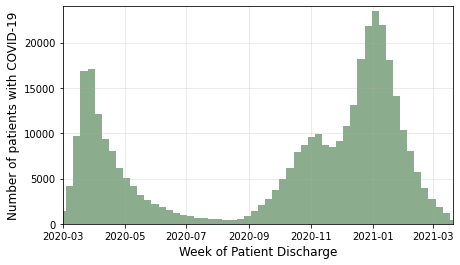

In [279]:

figN, axN = plt.subplots(figsize=(7,4))



MarkerSize = 50
CurveThickness = 5
zorderCurve = 0
Color1 = (26/255, 90/255, 30/255)
# axN.plot( df[DateFeature], df['Number Infections'],
#           marker=None, markersize=MarkerSize, linewidth=CurveThickness, color=Color1, alpha=0.6,
#           zorder=zorderCurve+1)

plt.bar( df[DateFeature], df['Number Infections'],
       width=df[DateFeature].diff()[1],
       color=Color1, alpha=0.5)

plt.grid(alpha=0.3)
plt.xlabel('Week of Patient Discharge', size=12);
plt.ylabel('Number of patients with COVID-19', size=12);
plt.ylim(0, 24000);
plt.xlim(df[DateFeature].min(), df[DateFeature].max());

Save = True
if Save:
    figN.savefig('NumberInfections.pdf', bbox_inches='tight', format='pdf', dpi=300)

# axN.plot( df[DateFeature], df['RollingAverage_Predictions']*df['Number Infections']/50,
#           marker=None, markersize=MarkerSize, linewidth=CurveThickness, color='red', alpha=0.4,
#           zorder=zorderCurve+1)

# df.head()
# axN2 = axN.twinx()
# axN2.plot( df[DateFeature], 100*df['Number NI']/df['Number Infections'],
#           marker=None, markersize=MarkerSize, linewidth=CurveThickness, alpha=0.4,
#           zorder=zorderCurve+1, color='blue')

# df[FilterDate]['RollingAverage_Predictions'].mean()


In [530]:

# FilterDate = df['Discharge date']>'2020-09-01'
# print(df['Predictions'][FilterDate].min())
# print((df['NC_Method1'][FilterDate]+df['NC_Method2_15'][FilterDate]).min())
# df['RollingAverage_Predictions'].mean()


### Focus on seven particular trusts for Keith's report

In [41]:

# Read files
df_Visualisation.head()
ReadCSV = True
if ReadCSV:
    df_Assembled = pd.read_csv(r'O:\GIRFT DiRAC\FlavienHardy\2_NosocomialInfections\src\0.processing\data\NI_Assembled.csv')


c:\users\flavien.hardy\onedrive - nhs improvement\desktop\fh_local\env\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [68]:

# Merge on SpellID
ColumnList = ['P_Spell_ID', 'ProvCode']
df_ProvCode = df_Assembled.loc[:, ColumnList]
df_Merged = pd.merge(df_Visualisation, df_ProvCode, on='P_Spell_ID')
df_Merged.head()

FilterWave1 = df_Merged.loc[:,'Infection Date'] <= pd.to_datetime('2020-08-01', format='%Y-%m-%d')
df_Merged.loc[:,'Wave'] = np.where(FilterWave1, 1, 2)

SevenTrusts = ['RJR', 'RHM', 'RHW', 'RMP', 'RA9', 'RH5', 'RBT']
SevenTrusts_Methods_Wave1 = []
SevenTrusts_Methods_Wave2 = []
SevenTrusts_Predictions_Wave1 = []
SevenTrusts_Predictions_Wave2 = []

for trust in SevenTrusts:
    # Methods: Wave 1
    Filter_Wave1 = (df_Merged['ProvCode']==trust) & (df_Merged['Wave']==1)
    df_trust = df_Merged[Filter_Wave1]
    Sum_Methods = df_trust.loc[:, 'NI_AllMethods'].sum()
    Count_Methods = df_trust.shape[0]
    print(Count_Methods)
    Prop_Methods = 100 * Sum_Methods / Count_Methods
    SevenTrusts_Methods_Wave1.append(Prop_Methods)
    
    # Methods: Wave 2
    Filter_Wave2 = (df_Merged['ProvCode']==trust) & (df_Merged['Wave']==2)
    df_trust = df_Merged[Filter_Wave2]
    Sum_Methods = df_trust.loc[:, 'NI_AllMethods'].sum()
    Count_Methods = df_trust.shape[0]
    Prop_Methods = 100 * Sum_Methods / Count_Methods
    SevenTrusts_Methods_Wave2.append(Prop_Methods)
    
    # Predictions: Wave 1
    Filter_Wave1 = (df_Merged['ProvCode']==trust) & (df_Merged['Wave']==1)
    df_trust = df_Merged[Filter_Wave1]
    Sum_Methods = df_trust.loc[:, 'Predictions Waves'].sum()
    Count_Methods = df_trust.shape[0]
    Prop_Methods = 100 * Sum_Methods / Count_Methods
    SevenTrusts_Predictions_Wave1.append(Prop_Methods)

    # Predictions: Wave 2
    Filter_Wave2 = (df_Merged['ProvCode']==trust) & (df_Merged['Wave']==2)
    df_trust = df_Merged[Filter_Wave2]
    Sum_Methods = df_trust.loc[:, 'Predictions Waves'].sum()
    Count_Methods = df_trust.shape[0]
    Prop_Methods = 100 * Sum_Methods / Count_Methods
    SevenTrusts_Predictions_Wave2.append(Prop_Methods)

d = { 'Trusts':SevenTrusts,
     'Wave1_Methods':SevenTrusts_Methods_Wave1, 'Wave2_Methods':SevenTrusts_Methods_Wave2,
     'Wave1_Model':SevenTrusts_Predictions_Wave1, 'Wave2_Model':SevenTrusts_Predictions_Wave2}

df_SevenTrusts = pd.DataFrame(data=d)

df_SevenTrusts


989
1502
913
658
141
330
781


,Trusts,Wave1_Methods,Wave2_Methods,Wave1_Model,Wave2_Model
0,RJR,20.323559,16.364772,30.839232,18.863210
1,RHM,2.263648,2.262997,6.657790,2.935780
2,RHW,6.462212,8.639911,10.405257,9.587514
3,RMP,10.486322,7.418398,17.021277,6.750742
4,RA9,4.255319,8.439898,5.673759,9.207161
5,RH5,4.848485,9.359606,15.454545,12.684729
6,RBT,15.364917,19.250551,23.559539,17.707568


In [62]:
print(list(df_Merged.columns))

['P_Spell_ID', 'Admission Date', 'Discharge Date', 'Diff_EPIstart_Admission', 'Infection Date', 'NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NC_Method4', 'NI_AllMethods', 'Predictions', 'UpperLimit', 'age_of_patient', 'Infection Date, Predictions', 'Predictions_Proba', 'Predictions_2', 'Predictions_3', 'Predictions Waves', 'ProvCode', 'Wave']


### Wrapping everything in a plot function

In [1651]:

def PlotCurves_Threshold(threshold, y_pred_test_proba, PlotCurves, LegendOn):
    
    DateFeature = 'Discharge Date'
    
    print('-------')
    print('Threshold:', threshold)
    
    # Applying model to test set
    
    y_pred_test = [1 if y_pred_test_proba[i][1]>threshold else 0 for i in range(len(y_pred_test_proba))]
#     y_pred_test_proba =  y_pred_test_proba[:,1]
#     print('NI rate on test set:', NI_Rate(y_pred_test), '%')

#     # Calculating AUROC on test set
#     fpr, tpr, threshold = metrics.roc_curve(y_application, y_pred_test_proba)
#     roc_auc = metrics.auc(fpr, tpr)
#     print('ROC AUC Value on test set: ', roc_auc)

    # Add Initial labels
    Methods = ['NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NC_Method4', 'NI_AllMethods']
    df_Visualisation = df_ini.loc[X_application.index, Methods]
    
    Dates = ['Admission_date', 'Discharge_date']
    df_Visualisation['Admission Date'] = pd.to_datetime(df_ini.loc[X_application.index]['Admission_date'], format='%Y-%m-%d')
    df_Visualisation['Discharge Date'] = pd.to_datetime(df_ini.loc[X_application.index]['Discharge_date'], format='%Y-%m-%d')
    df_Visualisation['Diff_EPIstart_Admission'] = df_ini.loc[X_application.index]['Diff_EPIstart_Admission']
    df_Visualisation['age_of_patient'] = df_ini.loc[X_application.index]['age_of_patient']

    # Add model predictions and discharge date
    df_Visualisation['Predictions'] = y_pred_test 
    
    # Add infection date for NIs
    Offset = df_Visualisation['Diff_EPIstart_Admission'].apply(lambda x: pd.Timedelta(x, unit='D'))
    
    # Add infection date for CIs
#     Filter_CI = (df_Visualisation['NI_AllMethods']==0) & (df_Visualisation['Diff_EPIstart_Admission']==0)
    Filter_CI = (df_Visualisation['Diff_EPIstart_Admission']==0)
    Filter_Age20 = (df_Visualisation['age_of_patient']<=20)
    Filter_Age2060 = (df_Visualisation['age_of_patient']>20) & (df_Visualisation['age_of_patient']<=60)
    Filter_Age6080 = (df_Visualisation['age_of_patient']>60) & (df_Visualisation['age_of_patient']<=80)
    Filter_Age80 = (df_Visualisation['age_of_patient']>80)
    Offset[Filter_CI & Filter_Age20] = pd.Timedelta(-1, unit='D')
    Offset[Filter_CI & Filter_Age2060] = pd.Timedelta(-7, unit='D')
    Offset[Filter_CI & Filter_Age6080] = pd.Timedelta(-5, unit='D')
    Offset[Filter_CI & Filter_Age80] = pd.Timedelta(-2, unit='D')
    
    df_Visualisation['Infection Date'] = df_Visualisation['Admission Date']+Offset
    
    # Add Upper Limit
    Filter1 = (df_ini.loc[X_application.index]['NC_Method1']+df_ini.loc[X_application.index]['NC_Method4']>=1)
    Filter2 = (df_ini.loc[X_application.index]['POD_EL']+df_ini.loc[X_application.index]['POD_DC']>=1) & (df_ini.loc[X_application.index]['Spell_Los']>2)
    Filter3 = (df_ini.loc[X_application.index]['POD_EM']==1) & (df_ini.loc[X_application.index]['Spell_Los']>2) & (df_ini.loc[X_application.index]['Diff_EPIstart_Admission']>0)
    
    df_Visualisation['UpperLimit'] = np.where(Filter1|Filter2|Filter3, 1, 0)


    # Reorder Columns
    ColumnList = ['Admission Date', 'Discharge Date', 'Infection Date',
                  'NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NC_Method4', 'NI_AllMethods',
                  'Predictions', 'UpperLimit']

    df_Visualisation = df_Visualisation[ColumnList]
    
    # Initialising lists
    PropList = []
    PropList_1 = []
    PropList_2_15 = []
    PropList_2_8 = []
    PropList_4 = []
    PropList_Predictions = []
    PropList_UpperLimit = []
    CountList = []

    StartDate_List = []
    EndDate_List = []
    StartDate_ini = Origin_DischargeDate

    for k in range(0, 56):

        # Limits of time period
        StartDate = StartDate_ini + k*relativedelta(days=7)
        EndDate = StartDate + relativedelta(days=7)
        StartDate_List.append(StartDate)
        EndDate_List.append(EndDate)

        # Segment of df within time period
        df_Visualisation['DatePeriod'] = np.where( (StartDate<=df_Visualisation[DateFeature]) & (df_Visualisation[DateFeature]<EndDate), 1, 0 )
        FilterDate = df_Visualisation['DatePeriod'] == 1 
        IndexList_Period = df_Visualisation[FilterDate].index
        
        # Add count of infections
        CountList.append(df_ini.loc[IndexList_Period].shape[0])


        # Calculate NI rate using all methods and predictions    
        Columns = ['NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NC_Method4','NI_AllMethods']
        dict = {}
        for column in Columns:
            Sum = df_ini.loc[IndexList_Period, column].sum()
            Count = df_ini.loc[IndexList_Period, column].count()
            Prop = 100 * Sum / Count
            dict[column]=Prop

        PropList_1.append(dict['NC_Method1'])
        PropList_2_15.append(dict['NC_Method2_15'])
        PropList_2_8.append(dict['NC_Method2_8'])
        PropList_4.append(dict['NC_Method4'])
        PropList.append(dict['NI_AllMethods'])

        # Add model predictions
        Sum = df_Visualisation[FilterDate]['Predictions'].sum()
        Count = df_Visualisation[FilterDate]['Predictions'].count()
        Prop = 100 * Sum / Count
        PropList_Predictions.append(Prop)
        
        # UpperLimit
        Sum = df_Visualisation[FilterDate]['UpperLimit'].sum()
        Count = df_Visualisation[FilterDate]['UpperLimit'].shape[0]
        Prop = 100 * Sum / Count
        PropList_UpperLimit.append(Prop)


        # Adding proportions into a dataframe
        d = {DateFeature:StartDate_List, 'NC_Method1':PropList_1,'NC_Method2_15':PropList_2_15,
             'NC_Method2_8':PropList_2_8, 'NC_Method4':PropList_4, 'NI_AllMethods':PropList,
             'Predictions':PropList_Predictions, 'Upper Limit':PropList_UpperLimit, 'Number Infections':CountList}
        df = pd.DataFrame(data=d)

        Window = 4
        # Add rolling average
        ColumnList = ['NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NC_Method4','NI_AllMethods',
                      'Predictions', 'Upper Limit', 'Number Infections']
        for column in ColumnList:
            df['RollingAverage_'+column] = df[column].rolling(window = Window).mean()
            
            
    # Plot options
    yMax = 28
    CurveOpacity = 0.8
    PointsOpacity = 0.4
#     Color1 = (26/255, 81/255, 37/255)
    Color1 = (26/255, 90/255, 30/255)
    Color2 = (239/255, 110/255, 120/255)
    Color3 = (56/255, 81/255, 156/255)
    Color4 = (25/255, 5/255, 5/255)
    CurveThickness = 5
    DataPoints = 0
    MarkerSize = 8
    zorderCurve = 1
    zorderPoints = 2        
            
    # Plot Curves
    if 'Predictions' in PlotCurves:
        # Plot curves : predictions
        plt.plot( df[DateFeature], df['RollingAverage_Predictions'],
                  marker=None, markersize=MarkerSize, linewidth=CurveThickness/1, color=Color2, alpha=CurveOpacity/2,
                  zorder=zorderCurve+3, label='Model Predictions'+'\n'+ r'$0.24 \leq$ threshold $\leq 0.30$' )

        plt.plot( df[DateFeature], df['Predictions'],
                  marker='o', markersize=MarkerSize, linewidth=DataPoints, color=Color2, alpha=PointsOpacity, zorder=zorderPoints+3 )

    if 'NI_AllMethods' in PlotCurves:
        # Plot curves : All Methods
        plt.plot( df[DateFeature], df['RollingAverage_NI_AllMethods'],
                  marker=None, markersize=MarkerSize, linewidth=CurveThickness, color=Color1, alpha=CurveOpacity,
                  zorder=zorderCurve+2, label='Methods 1 to 4' )

        plt.plot( df[DateFeature], df['NI_AllMethods'],
                  marker='o', markersize=MarkerSize, linewidth=DataPoints, color=Color1, alpha=PointsOpacity, zorder=zorderPoints+2 )

    if 'NC_Method1' in PlotCurves:
        # Plot curves : Method 1
        plt.plot( df[DateFeature], df['RollingAverage_NC_Method1'],
                  marker=None, markersize=MarkerSize, linewidth=CurveThickness, color=Color3, alpha=CurveOpacity,
                  zorder=zorderCurve, label='Method 1' )

        plt.plot( df[DateFeature], df['NC_Method1'],
                  marker='o', markersize=MarkerSize, linewidth=DataPoints, color=Color3, alpha=PointsOpacity, zorder=zorderPoints )

    if 'NC_Method1p2_15' in PlotCurves:
        # Plot curves : Method 1=2
        plt.plot( df[DateFeature], df['NC_Method1']+df['NC_Method2_15'],
                  marker='o', markersize=MarkerSize, linewidth=DataPoints, color=Color4, alpha=PointsOpacity,
                  zorder=zorderPoints+1 )

        plt.plot( df[DateFeature], (df['RollingAverage_NC_Method1']+df['RollingAverage_NC_Method2_15']),
                  marker=None, markersize=MarkerSize, linewidth=CurveThickness, color=Color4, alpha=0.6,
                  zorder=zorderCurve+1, label='Methods 1 and 2' )
    
    if 'Upper Limit' in PlotCurves:
        # Plot curves : Method 1=2
        plt.plot( df[DateFeature], df['Upper Limit'],
                  marker='o', markersize=MarkerSize, linewidth=DataPoints, color=Color4, alpha=PointsOpacity, zorder=zorderPoints+1 )

        plt.plot( df[DateFeature], (df['RollingAverage_Upper Limit']),
                  marker=None, markersize=MarkerSize, linewidth=CurveThickness, color=Color4, alpha=0.6,
                  zorder=zorderCurve+1, label='Upper Limit' )

    if 'Number Infections' in PlotCurves:
        # Add count of all infections
        ax_Nb = ax2.twinx()
        ax_Nb.set_ylim(0, 14)
        ax_Nb.set_axis_off()
        x = list( df[DateFeature].values )
        y = [0, 0.3]
        z = list( np.log(df['Number Infections']).rolling(window = 1).mean().values)
        Z = np.vstack( (z, z) )
        ax_Nb.pcolor(x, y, Z, zorder=1, alpha=0.9, cmap='BuPu')
        
        
    if LegendOn:
        # Legend box
        handles,labels=plt.gca().get_legend_handles_labels()
        order = [1, 3, 2, 4, 0]
#         order = [1, 3, 2, 0]
        Handles_Order = [handles[idx] for idx in order]
        Labels_Order = [labels[idx] for idx in order]
        legend1 = plt.legend(Handles_Order[0:3], Labels_Order[0:3], frameon=True, facecolor='black',
                             framealpha=0.1, fontsize=10, loc='upper left')
        plt.legend(Handles_Order[3:], Labels_Order[3:], frameon=True, facecolor='black', framealpha=0.1, fontsize=10, loc='upper right')
        plt.gca().add_artist(legend1)
        
    return list(df[DateFeature].values), list(df['RollingAverage_Predictions'].values)


-------
Threshold: 0.24
-------
Threshold: 0.3


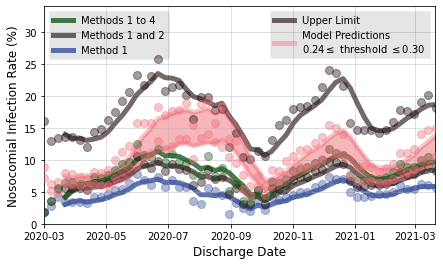

In [1653]:

fig2, ax2 = plt.subplots(figsize=(7,4))

yMax = 34
ax2.grid(b=True, alpha=0.5)
plt.ylim(0, yMax)
AlphaLines = 0.6
LineStyles = 'dashed'
AlphaZones = 0.15
zorderBack = 0

LockDowns = False
if LockDowns:
    # First lockdown
    plt.vlines(x=pd.to_datetime('2020-03-26'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
    plt.vlines(x=pd.to_datetime('2020-06-23'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
    ax2.axvspan(xmin=pd.to_datetime('2020-03-26'), xmax=pd.to_datetime('2020-06-23'), alpha = AlphaZones, zorder=zorderBack)

    # Second lockdown
    plt.vlines(x=pd.to_datetime('2020-11-05'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
    plt.vlines(x=pd.to_datetime('2020-12-02'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
    ax2.axvspan(xmin=pd.to_datetime('2020-11-05'), xmax=pd.to_datetime('2020-12-02'), alpha = AlphaZones, zorder=zorderBack)

    # Third lockdown
    plt.vlines(x=pd.to_datetime('2021-01-06'), ymin=0, ymax=yMax, linestyles=LineStyles, colors='black', alpha=AlphaLines, zorder=zorderBack)
    ax2.axvspan(xmin=pd.to_datetime('2021-01-06'), xmax=pd.to_datetime('2021-03-01'), alpha = AlphaZones, zorder=zorderBack)

y_pred_test_proba = clf_RF.predict_proba(X_application)

# Plotting curves
PlotCurves_All = ['NC_Method1', 'NC_Method1p2_15', 'NI_AllMethods', 'Predictions', 'Upper Limit', 'Number Infections']
PlotCurves = ['NC_Method1', 'NC_Method1p2_15', 'NI_AllMethods', 'Predictions', 'Upper Limit']
DateList1, Predictions1 = PlotCurves_Threshold(0.24, y_pred_test_proba, PlotCurves, LegendOn=True)

PlotCurves = ['Predictions']
DateList2, Predictions2 = PlotCurves_Threshold(0.30, y_pred_test_proba, PlotCurves, LegendOn=False)

# Fill area in between
ax2.fill_between(DateList2, Predictions1, Predictions2, color=Color2, alpha=0.5)

ax2.set_ylabel('Nosocomial Infection Rate (%)', size = 12)
ax2.set_xlabel('Discharge Date', size = 12)
plt.xlim(pd.to_datetime('2020-03-01', format='%Y-%m-%d'), pd.to_datetime('2021-03-20', format='%Y-%m-%d'))

Save = True
if Save:
    fig2.savefig('NI_Range_DischargeDate.pdf', bbox_inches='tight', format='pdf', dpi=300)
    


In [557]:

import rfpimp

I = rfpimp.permutation_importances(clf_RF, X_trainval, y_trainval, rfpimp.oob_classifier_accuracy)
I[0:50]



,Importance
Feature,
Spell_Los,0.0238
PropMaxPatientsWave_NonCovid,0.0114
PropMaxPatientsWave_Covid,0.0112
HFRS_Band_Severe,0.0094
CountSameDay_Covid,0.0086
age_of_patient,0.0072
Hopper_Index_3,0.0072
MORT,0.0068
CountSameDay_NonCovid,0.0064


In [1411]:

FeatureImportance = pd.DataFrame({'Features':list(X_trainval.columns), 'Importance':clf_RF.feature_importances_}).sort_values('Importance', ascending=False)
FeatureImportance[0:25]


,Features,Importance
3,Spell_Los,0.221723
33,PropMaxPatientsWave,0.055544
63,IMD_Barriers to Housing and Services Rank,0.046844
64,IMD_Living Environment Rank,0.041450
62,IMD_Crime Rank,0.041381
60,"IMD_Education, Skills and Training Rank",0.041047
61,IMD_Health Deprivation and Disability Rank,0.040899
32,CountSameDay,0.040034
0,age_of_patient,0.039267
30,Charlson_Score,0.026204


In [1187]:


from sklearn.inspection import permutation_importance
r = permutation_importance(clf_RF, X_trainval, y_trainval, n_repeats=1, random_state=0)
r


{'importances_mean': array([1.02104009e-02, 1.11597670e-03, 9.11642938e-03, 3.24890681e-02,
        3.66228973e-03, 1.28573090e-03, 7.97216031e-03, 2.66891329e-03,
        6.82160405e-04, 1.15055626e-03, 9.83945654e-04, 1.08485510e-02,
        8.29909433e-04, 4.00494173e-03, 7.19883561e-04, 4.87571792e-03,
        1.93331175e-03, 1.45548510e-03, 2.29482533e-04, 1.69754202e-04,
        1.37375160e-03, 1.62838290e-03, 4.27529102e-04, 1.66924965e-03,
        5.81565322e-04, 1.87358342e-03, 1.34860283e-03, 6.25575671e-04,
        7.01021983e-04, 3.77231560e-05, 1.11314746e-02, 8.64488993e-04,
        1.30270632e-02, 1.41901939e-02, 3.54283307e-03, 2.41742558e-03,
        1.67868044e-03, 1.89558859e-03, 2.50858988e-03, 3.56169465e-03,
        2.18479945e-03, 4.30358339e-03, 1.27630011e-03, 2.37341523e-03,
        1.97103490e-03, 9.02212149e-04, 7.79611892e-04, 8.89637763e-04,
        7.13596369e-04, 9.80802057e-04, 2.07477358e-03, 1.10340231e-03,
        2.85124188e-03, 1.39890037e-03, 3.40

In [1190]:

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2*r.importances_std[i]>0:
        print(f'{X_trainval.columns[i]:<8}'
              ': \t'
              f'{r.importances_mean[i]:.3f}')

Spell_Los: 	0.032
PropMaxPatientsWave: 	0.014
HFRS_Band_Severe: 	0.013
CountSameDay: 	0.013
dis_dest_Spell_Usual place : 	0.013
Charlson_Score: 	0.011
Total_Hopper_Domains: 	0.011
age_of_patient: 	0.010
MORT    : 	0.009
IMD_Barriers to Housing and Services Rank: 	0.008
Hopper_Index_3: 	0.008
IMD_Crime Rank: 	0.007
IMD_Health Deprivation and Disability Rank: 	0.007
IMD_Living Environment Rank: 	0.007
IMD_Education, Skills and Training Rank: 	0.007
cerebral_vasc: 	0.005
ICD10_J90X: 	0.004
heart_fail: 	0.004
region_North West: 	0.004
Hopper_Index_1: 	0.004
HFRS_Band_Moderate: 	0.004
ICD10_N390: 	0.004
ICD10_N179: 	0.004
ICD10_J189: 	0.003
ethnicity_updated_cat_White: 	0.003
ICD10_J181: 	0.003
Hopper_Index_4: 	0.003
ICD10_Z515: 	0.003
ICD10_Z501: 	0.002
ICD10_K590: 	0.002
ICD10_Z507: 	0.002
OPCS_Y981: 	0.002
ICD10_R33X: 	0.002
ICD10_I500: 	0.002
sex_Male: 	0.002
dementia: 	0.002
ICD10_R296: 	0.002
Renal_dis: 	0.002
ICD10_I489: 	0.002
diabetescoded: 	0.002
Diabetes_without: 	0.002
region_Lo

In [1717]:
df_ini.shape

(374244, 130)

# Group NI for presentation

In [493]:

# Read Assembled dataset
ReadCSV = True

if ReadCSV:
    df_Assembled = pd.read_csv(r'O:\GIRFT DiRAC\FlavienHardy\2_NosocomialInfections\src\0.processing\data\NI_Assembled.csv')
    

c:\users\flavien.hardy\onedrive - nhs improvement\desktop\fh_local\env\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


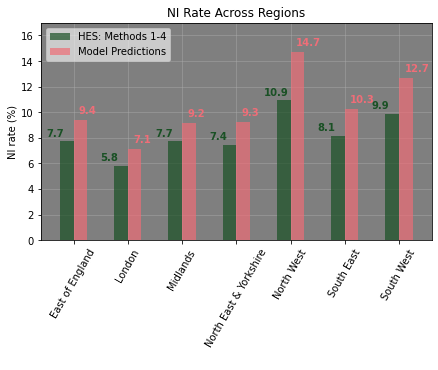

In [1751]:

fig4, ax4 = plt.subplots()

PlotAll = ['RegionalDistribution', 'RegionalNI_Rate']
Plot = 'RegionalNI_Rate'

# -------------------------------------
# Group NI by regions: original dataset

FilterNI = (df_Assembled['NI_AllMethods']==1)
FilterNHS = (df_Assembled['region']!='Non-NHS provider')
df_NI_All = df_Assembled[FilterNI & FilterNHS]
NI_AllSum = df_NI_All['NI_AllMethods'].sum()
Region_Count = df_Assembled[FilterNHS].groupby(by=['region'])['NI_AllMethods'].count()
if Plot == 'RegionalDistribution':
    dfg_region = df_NI_All.groupby(by=['region'])['NI_AllMethods'].count() * 100 / NI_AllSum
elif Plot == 'RegionalNI_Rate':
    dfg_region = df_NI_All.groupby(by=['region'])['NI_AllMethods'].count() * 100 / Region_Count

# -------------------------------------
# Group NI by regions: model predictions

df = X_application
Predictions = y_pred_application

df['Predictions'] = Predictions
NI_AllSum = df['Predictions'].sum()

RegionList = ['East of England',
             'London',
             'Midlands',
             'North East & Yorkshire',
             'North West',
             'South East',
             'South West']
d = {}
for region in RegionList:
    region_feature = 'region_'+region
    Filter = df[region_feature] == 1
    NI_Region = df[Filter]['Predictions']
    NI_Region_Sum = NI_Region.sum()
    Region_Count = df[region_feature].sum()
    if Plot == 'RegionalDistribution':
        d[region_feature] = 100*NI_Region_Sum/NI_AllSum
    elif Plot == 'RegionalNI_Rate':
        d[region_feature] = 100*NI_Region_Sum/Region_Count
    
# -------------------------------------
# Common plot

df = X_application
PlotAll = ['M14','Comparison']

df_Regions_Pred = pd.DataFrame(data={'Regions':RegionList, 'HES: Methods 1-4':dfg_region.values, 'Model Predictions':d.values()})    

Color1 = (26/255, 81/255, 37/255)
Color2 = (239/255, 110/255, 120/255)

def PlotRegions(PlotList):

    if PlotList == 'Comparison':
        barlist = df_Regions_Pred.plot.bar( figsize=(7,4), ax = ax4,
                                 x='Regions',
                                 color=[Color1, Color2],
                                 zorder=2, alpha=0.7 )

        for index,value in enumerate(df_Regions_Pred['HES: Methods 1-4'].values):
            plt.text(index - 0.5, 0.4+df_Regions_Pred.loc[index,'HES: Methods 1-4'],
                     str('%0.1f' % value), color=Color1,
                     weight='bold')
            
        for index,value in enumerate(df_Regions_Pred['Model Predictions'].values):
            plt.text(index+0.1, 0.5+df_Regions_Pred.loc[index,'Model Predictions'],
                     str('%0.1f' % value), color=Color2,
                     weight='bold')            

    if PlotList == 'M14':

        barlist = df_Regions_Pred.plot.bar( figsize=(7,4), ax = ax4,
                                 x='Regions', y='HES: Methods 1-4',
                                 color=Color1,
                                 zorder=2, alpha=0.7)

        for index,value in enumerate(df_Regions_Pred['HES: Methods 1-4'].values):
            plt.text(index - 0.2, 0.4+df_Regions_Pred.loc[index,'HES: Methods 1-4'],
                     str('%0.1f' % value), color=Color1,
                     weight='bold')

    plt.grid(alpha=0.5, zorder=0)
#     plt.ylabel('Percentage of NI (%)')
#     plt.ylim(0, 30)
    plt.xlim(-0.6, 6.6)
    plt.xlabel(' ')
    plt.xticks(rotation='60')
#     plt.title('Regional Distribution of NIs')
    ax4.legend().get_frame().set_linewidth(0)
    plt.legend(frameon=True, facecolor='white', framealpha=0.6)

if Plot == 'RegionalDistribution':
    plt.ylabel('Percentage of NI (%)')
    plt.title('Regional Distribution of NIs')
    plt.ylim(0, 17)
elif Plot == 'RegionalNI_Rate':
    plt.ylabel('NI rate (%)')
    plt.title('NI Rate Across Regions')
    plt.ylim(0, 17)

PlotAll = ['RegionalDistribution', 'RegionalNI_Rate']
PlotRegions('Comparison')


# -------------------------------------
Save = False
if Save:
    fig4.savefig('NIRate_Grouped_Regions_M1234.pdf', bbox_inches='tight', format='pdf', dpi=300)



In [1744]:
(1/7)*(9.4+7.1+9.2+9.3+14.7+10.3+12.7)

10.385714285714286

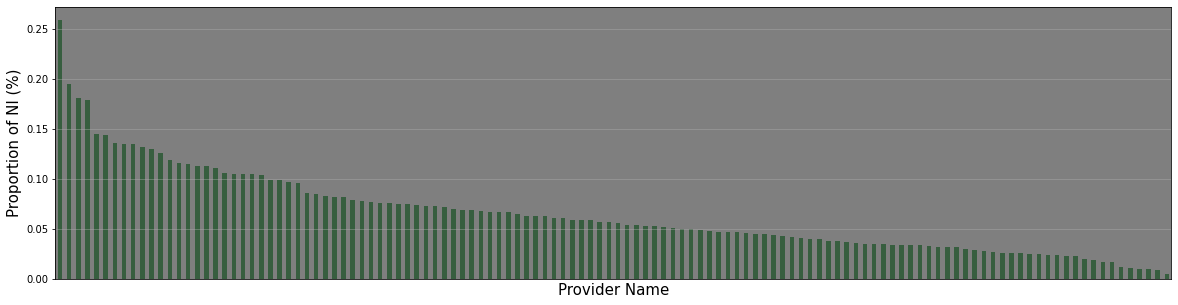

In [596]:

fig5, ax5 = plt.subplots()

N = df_Assembled.shape[0]
# Group NI by trusts
dfg = (100*(df_NI_All.groupby(by=['Provider_Name'])['NI_AllMethods']).count()/N).sort_values(ascending=False)
dfg.plot(kind='bar', figsize=(20,5), zorder=1, color=Color, alpha=0.7)
plt.grid(alpha=0.5, zorder=0)
plt.ylabel('Proportion of NI (%)', fontsize=15)
plt.xlabel('Provider Name', fontsize=15)
plt.xticks([])

Save = True
if Save:
    fig5.savefig('NI_Grouped_ProviderName.pdf', bbox_inches='tight', format='pdf', dpi=300)



## Test: PLS for IMD Scores

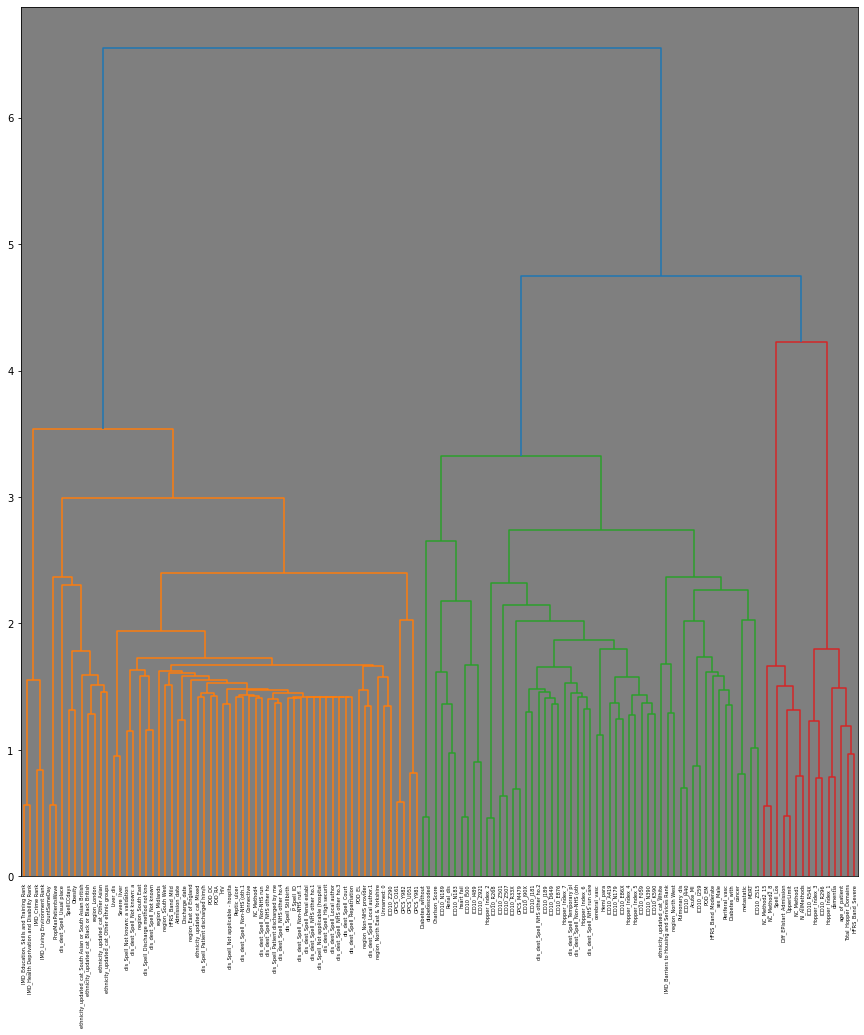

In [1282]:

from scipy.stats import spearmanr
from scipy.cluster import hierarchy

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,16))
fig, (ax1) = plt.subplots(1, 1, figsize=(15,16))
ColumnList =  ['IMD_Education, Skills and Training Rank',
             'IMD_Health Deprivation and Disability Rank',
             'IMD_Crime Rank',
             'IMD_Barriers to Housing and Services Rank',
             'IMD_Living Environment Rank',
             'MORT',
             'NI_AllMethods']
X = df_ini
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=list(X.columns), ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

# ax2.imshow(corr[dendro['leaves'],:][:, dendro['leaves']])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
# ax2.set_yticklabels(dendro['ivl'])


In [ ]:

IMD_Barriers to Housing and Services Rank: 	0.008
Hopper_Index_3: 	0.008
IMD_Crime Rank: 	0.007
IMD_Health Deprivation and Disability Rank: 	0.007
IMD_Living Environment Rank: 	0.007
IMD_Education, Skills and Training Rank: 	0.007
    

## Funnel plot for trust-wide variations

In [113]:
# list(df_ini.columns)
# # NI_AllMethods

# ColumnList = ['region_East of England',
#              'region_London',
#              'region_Midlands',
#              'region_North East & Yorkshire',
#              'region_North West',
#              'region_South East',
#              'region_South West',
#              'NI_AllMethods']
# df_Regions = df_ini[ColumnList]
# df_Regions


In [1363]:

# ----------------------------------
# TESTING: visualise time evolution of methods 1-4

StartDate_ini = Origin_DischargeDate
Periods_List = [StartDate_ini + relativedelta(weeks=delta) for delta in range(57)]
# Periods_List = [StartDate_ini + 1*relativedelta(months=delta) for delta in range(12)]
StartDate_List = Periods_List[0:-1]
EndDate_List = Periods_List[1:]

# Add infection date
df_Visualisation['Diff_EPIstart_Admission'] = df_ini.loc[X_application.index]['Diff_EPIstart_Admission']
df_Visualisation['Admission Date'] = pd.to_datetime(df_Visualisation['Admission Date'])
Offset = df_Visualisation['Diff_EPIstart_Admission'].apply(lambda x: pd.Timedelta(x, unit='D'))
df_Visualisation['Infection Date'] = df_Visualisation['Admission Date']+Offset
df_Visualisation.head(20)

DateFeature = 'Discharge Date'

SumList = []
CountList = []
PropList = []
SumList_Predictions = []
CountList_Predictions = []
PropList_Predictions = []
SumList_UpperLimit = []
CountList_UpperLimit = []
PropList_UpperLimit = []
for idx, startdate in enumerate(StartDate_List):
    # idx = 0
    # startdate = StartDate_List[idx]
    # enddate = EndDate_List[idx]
    
    enddate = EndDate_List[idx]
    FilterDate = (startdate<=df_Visualisation[DateFeature]) & (df_Visualisation[DateFeature]<enddate)
    df_Period = df_Visualisation[FilterDate].sort_values(by=['Admission Date'])

    # AllMethods
#     Sum = df_Period['NI_AllMethods'].sum()
    Filter = df_Period['NC_Method1']+df_Period['NC_Method2_15']>=1
    Sum = df_Period[ Filter ]['NC_Method1'].count()
    Count = df_Period['NI_AllMethods'].shape[0]
    Prop = 100 * Sum / Count
    SumList.append(Sum)
    CountList.append(Count)
    PropList.append(Prop)
    
    # Predictions
    Sum = df_Period['Predictions'].sum()
    Count = df_Period['Predictions'].shape[0]
    Prop = 100 * Sum / Count
    SumList_Predictions.append(Sum)
    CountList_Predictions.append(Count)
    PropList_Predictions.append(Prop)
    
    # UpperLimit
    Sum = df_Period['UpperLimit'].sum()
    Count = df_Period['UpperLimit'].shape[0]
    Prop = 100 * Sum / Count
    SumList_UpperLimit.append(Sum)
    CountList_UpperLimit.append(Count)
    PropList_UpperLimit.append(Prop)
    
DataDict = {'Start Date':StartDate_List, 'End Date':EndDate_List,
            'Sum': SumList, 'Count':CountList, 'Prop':PropList,
            'Sum_Pred': SumList_Predictions, 'Count_Pred':CountList_Predictions, 'Prop_Pred':PropList_Predictions,
            'Sum_UpperLimit': SumList_UpperLimit, 'Count_UpperLimit':CountList_UpperLimit, 'Prop_UpperLimit':PropList_UpperLimit}    
df_Vis2 = pd.DataFrame(data=DataDict)

# ColumnList = ['Sum', 'Count', 'Prop']
# Window = 4
# for column in ColumnList:
#     df_Vis2['RollingAverage_'+column] = df_Vis2[column].rolling(window = Window).mean()

# Add Rolling-Averages
ColumnList = ['Sum', 'Count', 'Sum_Pred', 'Count_Pred', 'Sum_UpperLimit', 'Count_UpperLimit']
Window = 4
for column in ColumnList:
    df_Vis2['RollingAverage_'+column] = df_Vis2[column].rolling(window = Window).mean()

df_Vis2['RollingAverage_Prop'] = 100 * df_Vis2['RollingAverage_Sum'] / df_Vis2['RollingAverage_Count']
df_Vis2['RollingAverage_Prop_Pred'] = 100 * df_Vis2['RollingAverage_Sum_Pred'] / df_Vis2['RollingAverage_Count_Pred']
df_Vis2['RollingAverage_Prop_UpperLimit'] = 100 * df_Vis2['RollingAverage_Sum_UpperLimit'] / df_Vis2['RollingAverage_Count_UpperLimit']

df_Vis2.head(2)


,Start Date,End Date,Sum,Count,Prop,Sum_Pred,Count_Pred,Prop_Pred,Sum_UpperLimit,Count_UpperLimit,Prop_UpperLimit,RollingAverage_Sum,RollingAverage_Count,RollingAverage_Sum_Pred,RollingAverage_Count_Pred,RollingAverage_Sum_UpperLimit,RollingAverage_Count_UpperLimit,RollingAverage_Prop,RollingAverage_Prop_Pred,RollingAverage_Prop_UpperLimit
0,2020-03-01,2020-03-08,0,6,0.000000,0,6,0.000000,1,6,16.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-08,2020-03-15,4,47,8.510638,2,47,4.255319,10,47,21.276596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NameError: name 'df_Vis2' is not defined

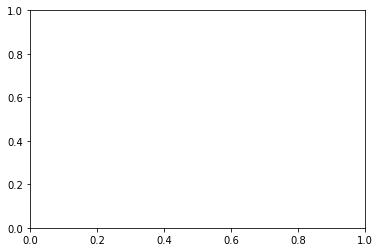

In [139]:

# --------------
# Number of NI
figA, axA = plt.subplots()
axA.plot(EndDate_List, df_Vis2['RollingAverage_Prop'], color='black')
axA.plot(EndDate_List, df_Vis2['RollingAverage_Prop_Pred'], color='blue')
axA.plot(EndDate_List, df_Vis2['RollingAverage_Prop_UpperLimit'], color='green')
yMax = 350
axA.set_ylim([0, yMax])
axA.grid(b=True, alpha=0.5)

# --------------
# Count of total infections
axB = axA.twinx()
axB.plot(EndDate_List, df_Vis2['RollingAverage_Count'], color='red')
axB.set_ylim([0, 10*yMax])

# --------------
# Upper Limit
# axD = axB.twinx()
# axD.plot(EndDate_List, df_Vis2['RollingAverage_Sum_UpperLimit'], color='green')
# axD.set_ylim([0, 10*yMax])

# --------------
# NI infection rate
# figC, axC = plt.subplots()
# axC.plot(EndDate_List, df_Vis2['RollingAverage_Prop'], color='black')
# axC.plot(EndDate_List, df_Vis2['RollingAverage_Prop_Pred'], color='blue')
# axC.set_ylim([0,30])
# axC.hlines(y=10, xmin=pd.to_datetime('01/03/2020', format='%d/%m/%Y'), xmax=pd.to_datetime('31/03/2021', format='%d/%m/%Y'))
# axC.grid(b=True, alpha=0.5)


In [4]:

df_ini.head(5)

# df_Visualisation['Admission Date'] = pd.to_datetime(df_Visualisation['Admission Date'])
# Offset = df_Visualisation['Diff_EPIstart_Admission'].apply(lambda x: pd.Timedelta(x, unit='D'))
# df_Visualisation['Infection Date'] = df_Visualisation['Admission Date']+Offset
# df_Visualisation.head(20)



,Unnamed: 0,P_Spell_ID,IMD_score,procedure_group,age_of_patient,SpellCCdays,MORT,Spell_Los,Admission_date,Discharge_date,...,dis_dest_Spell_Non-NHS run,dis_dest_Spell_Non-NHS run .1,dis_dest_Spell_Not known,dis_dest_Spell_Not known: a,dis_dest_Spell_Penal establ,dis_dest_Spell_Repatriation,dis_dest_Spell_Temporary pl,HFRS_Band_Mild,HFRS_Band_Moderate,HFRS_Band_Severe
0,0,1487000,25,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,38,0.0,0,54,2021-02-05,2021-03-31,...,0,0,0,0,0,0,0,0,0,0
1,1,2169012,9,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,75,0.0,0,7,2021-03-24,2021-03-31,...,0,0,0,0,0,0,0,0,0,1
2,2,2201273,2,W461~Z943~U212~Y982~Z924~Z401~U051~Y981~-1~-1~...,90,0.0,0,90,2020-12-31,2021-03-31,...,0,0,0,0,0,0,0,0,0,1
3,3,2947750,11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,39,0.0,0,9,2021-03-22,2021-03-31,...,0,0,0,0,0,0,0,0,0,0
4,4,3445944,30,U212~Y981~Z411~Z941~Z413~Z941~Z421~X403~X404~X...,52,0.0,0,55,2021-02-04,2021-03-31,...,0,0,0,0,0,0,0,0,0,0


In [9]:

# # Find distributions of ethnicities, mortalities

# ColumnList = [ 'ethnicity_updated_cat_Black or Black British',
#              'ethnicity_updated_cat_Mixed',
#              'ethnicity_updated_cat_Other Asian',
#              'ethnicity_updated_cat_Other ethnic groups',
#              'ethnicity_updated_cat_South Asian or South Asian British',
#              'ethnicity_updated_cat_White',
#              'MORT',
#              'Admission_date',
#              'sex_Male']

ColumnList = 'IMD_score'
Filter = df_ini['NI_AllMethods']==1
df_Sub = df_ini[Filter][ColumnList]
df_Sub.describe()

# df_Sub['Admission_date'] = pd.to_datetime(df_Sub['Admission_date'], format='%Y-%m-%d')
# FirstWave_end = pd.to_datetime('31/07/2020', format='%d/%m/%Y')
# FilterDate = df_Sub['Admission_date']<= FirstWave_end
# df_Sub['Wave'] = np.where(FilterDate, 1, 2)
# FilterWave = df_Sub['Wave'] == 1

# df_Sub['sex_Male'].describe()



count    29896.000000
mean        22.754616
std         15.966225
min          0.000000
25%         10.000000
50%         19.000000
75%         30.000000
max         88.000000
Name: IMD_score, dtype: float64

In [253]:

# # Venn diagrams of methods 1 to 4

# from venn import venn
# from matplotlib_venn import venn3

# Filter1 = df_ini['NC_Method1'] == 1
# Filter2 = (df_ini['NC_Method2_15'] == 1)
# Filter3 = (df_ini['NC_Method2_8'] == 1) & (df_ini['NC_Method2_15'] == 0)
# Filter4 = df_ini['NC_Method4'] == 1
# Set1 = df_ini[Filter1]['P_Spell_ID']
# Set2 = df_ini[Filter2]['P_Spell_ID']
# Set3 = df_ini[Filter3]['P_Spell_ID']
# Set4 = df_ini[Filter4]['P_Spell_ID']

# Methods = {
#     'Method 1': set(Set1.values),
#     'Method 2': set(Set2.values),
#     'Method 3': set(Set3.values),
#     'Method 4': set(Set4.values)
# }


# # for item in set(Set1.values):
# #     print (item)
